In [1]:
import os
import sys
import pathlib
import pickle as pkl
import json

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import torch
import torchvision

from torch.utils.data import DataLoader, Subset

from tqdm import tqdm

import fir.utils.time
import fir.utils.mem

from time import time
from datetime import datetime

import pprint

import itertools

import copy

In [2]:
def load_json_dict(
    json_filename
):

    with open(json_filename, 'r') as json_file:
        json_dict = json.load(json_file)

    return json_dict


def extract_preview_data(
    exp_dirname
):

    preview_data = {}

    # Experiment data

    exp_data_filename = os.path.join(exp_dirname, "train_ret_DDP_preview__data.json")
    exp_data = load_json_dict(exp_data_filename)

    preview_data["backbone"] = exp_data["settings"]["backbone"]["class"]
    preview_data["img_size"] = exp_data["settings"]["backbone"]["img_size"]
    preview_data["num_gpus"] = len(exp_data["settings"]["gpu_usage"])
    preview_data["batch_size"] = exp_data["settings"]["stage_1"]["data_loading"]["batch_size"]
    preview_data["num_workers"] = exp_data["settings"]["stage_1"]["data_loading"]["num_workers"]
    preview_data["autocast"] = exp_data["settings"]["stage_1"]["autocast"]["enabled"]

    # Experiment logs 

    preview_data["s1_epoch_time"] = None
    preview_data["s1_gpu_gib"] = None
    preview_data["s2_epoch_time"] = None
    preview_data["s2_gpu_gib"] = None

    exp_logs_filename = os.path.join(exp_dirname, "train_ret_DDP_preview__logs.txt")
    exp_logs_file = open(exp_logs_filename, "r")

    for line in exp_logs_file.readlines():
        
        if "Stage 1 Preview full_time" in line:
            tkns = line.split()
            preview_data["s1_epoch_time_s"] = float(tkns[4])

        if "Stage 1 Preview gpu_mem_b" in line:
            tkns = line.split()
            preview_data["s1_gpu_mem_b"] = int(tkns[4])

        if "Stage 2 Preview full_time" in line: 
            tkns = line.split()
            preview_data["s2_epoch_time_s"] = float(tkns[4])

        if "Stage 2 Preview gpu_mem_b" in line:
            tkns = line.split()
            preview_data["s2_gpu_mem_b"] = int(tkns[4])

    exp_logs_file.close()    

    return preview_data

In [3]:
preview_data_df = pd.DataFrame({
    "backbone": pd.Series(dtype="str"),
    "img_size": pd.Series(dtype="int"),
    "num_gpus": pd.Series(dtype="int"),
    "batch_size": pd.Series(dtype="int"),
    "num_workers": pd.Series(dtype="int"),
    "autocast": pd.Series(dtype="bool"),
    "s1_epoch_time_s": pd.Series(dtype="float"),
    "s1_gpu_mem_b": pd.Series(dtype="int"),
    "s2_epoch_time_s": pd.Series(dtype="float"),
    "s2_gpu_mem_b": pd.Series(dtype="int")
})

#

idxs = []

exp_sub_dirname_list = [
    "cvt_21-384-22k",
    "efficientnet_v2_s",
    "swint_v2_t"
]

for exp_sub_dirname in exp_sub_dirname_list:

    exp_dirname = os.path.join(
        pathlib.Path.home(),
        "data",
        "fashion_retrieval",
        "ret_test_DDP_2",
        exp_sub_dirname
    )

    for exp_sub_sub_dirname in os.listdir(exp_dirname):

        full_exp_dirname = os.path.join(
            exp_dirname, 
            exp_sub_sub_dirname
        )

        full_logs_filename = os.path.join(
            full_exp_dirname,
            "train_ret_DDP_preview__logs.txt"
        )

        preview_data = (extract_preview_data(full_exp_dirname))
        preview_data_df.loc[len(preview_data_df)] = preview_data

idxs.sort()

In [4]:
preview_data_df

,backbone,img_size,num_gpus,batch_size,num_workers,autocast,s1_epoch_time_s,s1_gpu_mem_b,s2_epoch_time_s,s2_gpu_mem_b
0,CvTransformerB21I384D22kBackbone,256,2,4,2,True,87910.485233,9.687532e+08,179225.700301,3.596485e+09
1,CvTransformerB21I384D22kBackbone,384,3,4,4,True,91807.157868,2.036204e+09,213185.714111,9.078440e+09
2,CvTransformerB21I384D22kBackbone,256,1,16,8,True,92630.190591,1.530790e+09,219387.574264,1.052338e+10
3,CvTransformerB21I384D22kBackbone,384,4,16,4,True,62461.491455,5.372772e+09,NaN,NaN
4,CvTransformerB21I384D22kBackbone,256,4,32,4,False,23873.333120,2.923299e+09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
715,SwinTransformerV2TinyBackbone,384,4,64,4,True,32937.182495,7.337804e+09,NaN,NaN
716,SwinTransformerV2TinyBackbone,256,3,32,2,False,20917.876630,1.937637e+09,NaN,NaN
717,SwinTransformerV2TinyBackbone,256,3,4,4,True,34883.110806,9.813361e+08,75820.376175,3.036545e+09
718,SwinTransformerV2TinyBackbone,256,3,32,8,False,22659.640517,1.943929e+09,NaN,NaN


---

In [5]:
def plot_num_workers_comparison(
    backbone,
    img_size,
    num_gpus,
    autocast,
    metric
):

    data_df = preview_data_df.copy()
    data_df = data_df[
        (data_df["backbone"] == backbone) &\
        (data_df["img_size"] == img_size) &\
        (data_df["num_gpus"] == num_gpus) &\
        (data_df["autocast"] == autocast)
    ]

    #

    batch_size_list = data_df["batch_size"].unique()
    batch_size_list.sort()

    #

    fig, axs = plt.subplots(ncols=len(batch_size_list), nrows=1, figsize=(24, 6))

    for batch_size_idx, batch_size in enumerate(batch_size_list):

        data_df_2 = data_df[data_df["batch_size"] == batch_size].sort_values("num_workers")

        if metric == "time":
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_epoch_time_s"] / 3600, width = 0.4, label="Stage 1")
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_epoch_time_s"] / 3600, width = 0.4, label="Stage 2")
            axs[batch_size_idx].set_ylabel("hours")

        if metric == "mem":
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_gpu_mem_b"] / (10**9), width = 0.4, label="Stage 1")
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_gpu_mem_b"] / (10**9), width = 0.4, label="Stage 2")
            axs[batch_size_idx].set_ylabel("GiB")

        axs[batch_size_idx].set_xticks(ticks=range(len(data_df_2)), labels=data_df_2["num_workers"])

        axs[batch_size_idx].set_title("batch_size: {:d}".format(batch_size))
        axs[batch_size_idx].set_xlabel("num_workers")

        axs[batch_size_idx].grid(axis="y")

        axs[batch_size_idx].set_xlim((-0.5, len(data_df_2) - 0.5))

        y_pos_diff = (axs[batch_size_idx].get_ylim()[1] - axs[batch_size_idx].get_ylim()[0]) * 0.01

        if metric == "time":          
            for x_pos, time in zip(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_epoch_time_s"]):
                if not np.isnan(time):
                    y_pos = (time / 3600) + y_pos_diff
                    time_str = fir.utils.time.sprint_fancy_time_diff(time)
                    time_str = ":".join(time_str.split(":")[:2])
                    axs[batch_size_idx].text(x_pos, y_pos, time_str, ha="center")
            for x_pos, time in zip(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_epoch_time_s"]):
                if not np.isnan(time):
                    y_pos = (time / 3600) + y_pos_diff
                    time_str = fir.utils.time.sprint_fancy_time_diff(time)
                    time_str = ":".join(time_str.split(":")[:2])
                    axs[batch_size_idx].text(x_pos, y_pos, time_str, ha="center")

        if metric == "mem":
            for x_pos, mem in zip(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_gpu_mem_b"]):
                if not np.isnan(mem):
                    y_pos = (mem / (10**9)) + y_pos_diff
                    mem_str = fir.utils.mem.sprint_fancy_num_bytes(mem, unit="GiB")
                    mem_str = mem_str.split(" ")[0]
                    axs[batch_size_idx].text(x_pos, y_pos, mem_str, ha="center")
            for x_pos, mem in zip(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_gpu_mem_b"]):
                if not np.isnan(mem):
                    y_pos = (mem / (10**9)) + y_pos_diff
                    mem_str = fir.utils.mem.sprint_fancy_num_bytes(mem, unit="GiB")
                    mem_str = mem_str.split(" ")[0]
                    axs[batch_size_idx].text(x_pos, y_pos, mem_str, ha="center")

    title_lines = []
    title_lines.append("{:s} comparison".format(metric))
    title_lines.append("backbone: {:s}".format(backbone))
    title_lines.append("img_size: {:d}".format(img_size))
    title_lines.append("num_gpus: {:d}".format(num_gpus))
    title_lines.append("autocast: {:s}".format(str(autocast)))

    plt.suptitle("\n".join(title_lines))
    fig.tight_layout()

    plt.show()

In [6]:
def plot_gpus_batch_size_comparison(
    backbone,
    img_size,
    num_workers,
    autocast,
    metric
):

    data_df = preview_data_df.copy()
    data_df = data_df[
        (data_df["backbone"] == backbone) &\
        (data_df["img_size"] == img_size) &\
        (data_df["num_workers"] == num_workers) &\
        (data_df["autocast"] == autocast)
    ]

    #

    batch_size_list = data_df["batch_size"].unique()
    batch_size_list.sort()

    #

    fig, axs = plt.subplots(ncols=len(batch_size_list), nrows=1, figsize=(24, 6))

    for batch_size_idx, batch_size in enumerate(batch_size_list):

        data_df_2 = data_df[data_df["batch_size"] == batch_size].sort_values("num_gpus")

        if metric == "time":
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_epoch_time_s"] / 3600, width = 0.4, label="Stage 1")
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_epoch_time_s"] / 3600, width = 0.4, label="Stage 2")
            axs[batch_size_idx].set_ylabel("hours")

        if metric == "mem":
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_gpu_mem_b"] / (10**9), width = 0.4, label="Stage 1")
            axs[batch_size_idx].bar(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_gpu_mem_b"] / (10**9), width = 0.4, label="Stage 2")
            axs[batch_size_idx].set_ylabel("GiB")

        axs[batch_size_idx].set_xticks(ticks=range(len(data_df_2)), labels=data_df_2["num_gpus"])

        axs[batch_size_idx].set_title("batch_size: {:d}".format(batch_size))
        axs[batch_size_idx].set_xlabel("num_gpus")

        axs[batch_size_idx].grid(axis="y")

        axs[batch_size_idx].set_xlim((-0.5, len(data_df_2) - 0.5))

        y_pos_diff = (axs[batch_size_idx].get_ylim()[1] - axs[batch_size_idx].get_ylim()[0]) * 0.01

        if metric == "time":          
            for x_pos, time in zip(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_epoch_time_s"]):
                if not np.isnan(time):
                    y_pos = (time / 3600) + y_pos_diff
                    time_str = fir.utils.time.sprint_fancy_time_diff(time)
                    time_str = ":".join(time_str.split(":")[:2])
                    axs[batch_size_idx].text(x_pos, y_pos, time_str, ha="center")
            for x_pos, time in zip(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_epoch_time_s"]):
                if not np.isnan(time):
                    y_pos = (time / 3600) + y_pos_diff
                    time_str = fir.utils.time.sprint_fancy_time_diff(time)
                    time_str = ":".join(time_str.split(":")[:2])
                    axs[batch_size_idx].text(x_pos, y_pos, time_str, ha="center")

        if metric == "mem":
            for x_pos, mem in zip(np.arange(len(data_df_2)) - 0.2, data_df_2["s1_gpu_mem_b"]):
                if not np.isnan(mem):
                    y_pos = (mem / (10**9)) + y_pos_diff
                    mem_str = fir.utils.mem.sprint_fancy_num_bytes(mem, unit="GiB")
                    mem_str = mem_str.split(" ")[0]
                    axs[batch_size_idx].text(x_pos, y_pos, mem_str, ha="center")
            for x_pos, mem in zip(np.arange(len(data_df_2)) + 0.2, data_df_2["s2_gpu_mem_b"]):
                if not np.isnan(mem):
                    y_pos = (mem / (10**9)) + y_pos_diff
                    mem_str = fir.utils.mem.sprint_fancy_num_bytes(mem, unit="GiB")
                    mem_str = mem_str.split(" ")[0]
                    axs[batch_size_idx].text(x_pos, y_pos, mem_str, ha="center")

    title_lines = []
    title_lines.append("{:s} comparison".format(metric))
    title_lines.append("backbone: {:s}".format(backbone))
    title_lines.append("img_size: {:d}".format(img_size))
    title_lines.append("num_workers: {:d}".format(num_workers))
    title_lines.append("autocast: {:s}".format(str(autocast)))

    plt.suptitle("\n".join(title_lines))
    fig.tight_layout()

    plt.show()

Examples

---

# Image size: 384px

BACKBONE: CvTransformerB21I384D22kBackbone


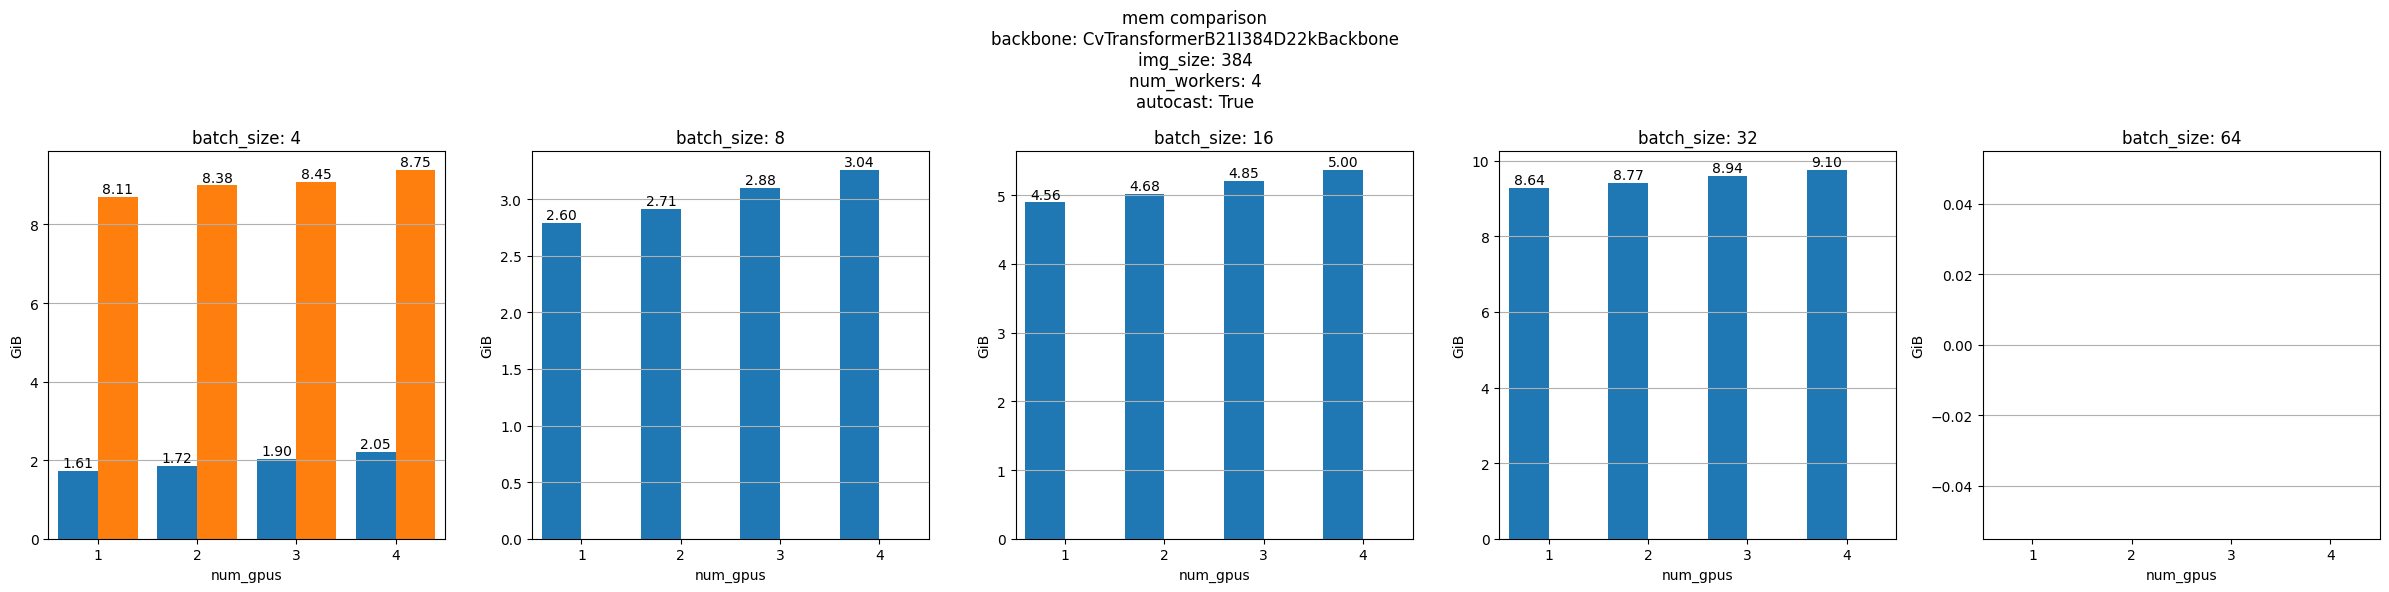

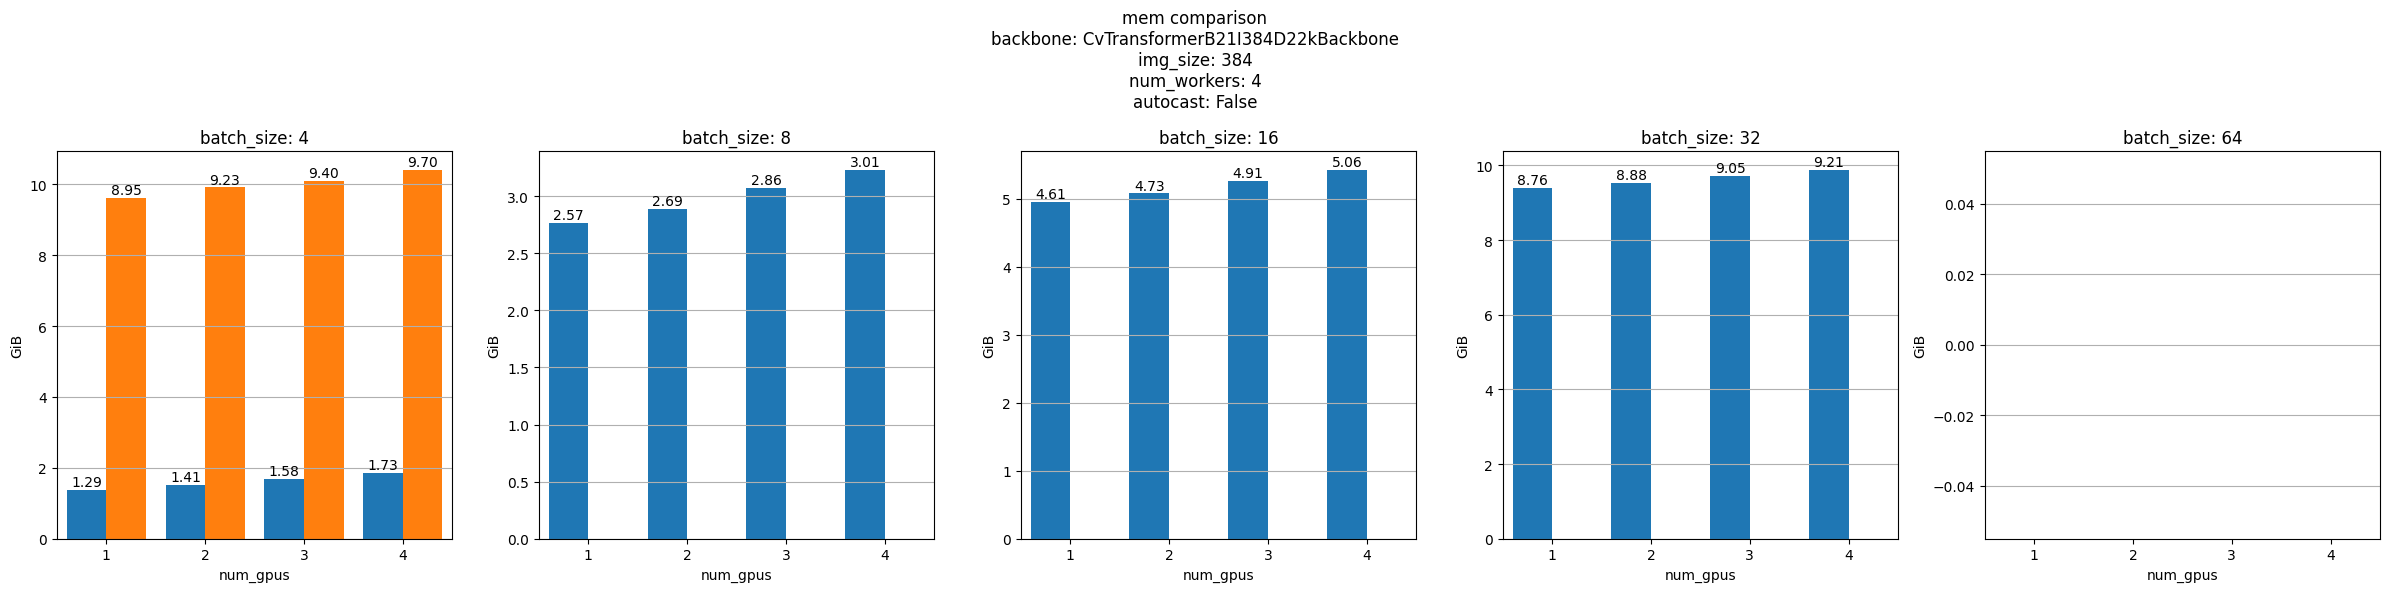

BACKBONE: EfficientNetV2SmallBackbone


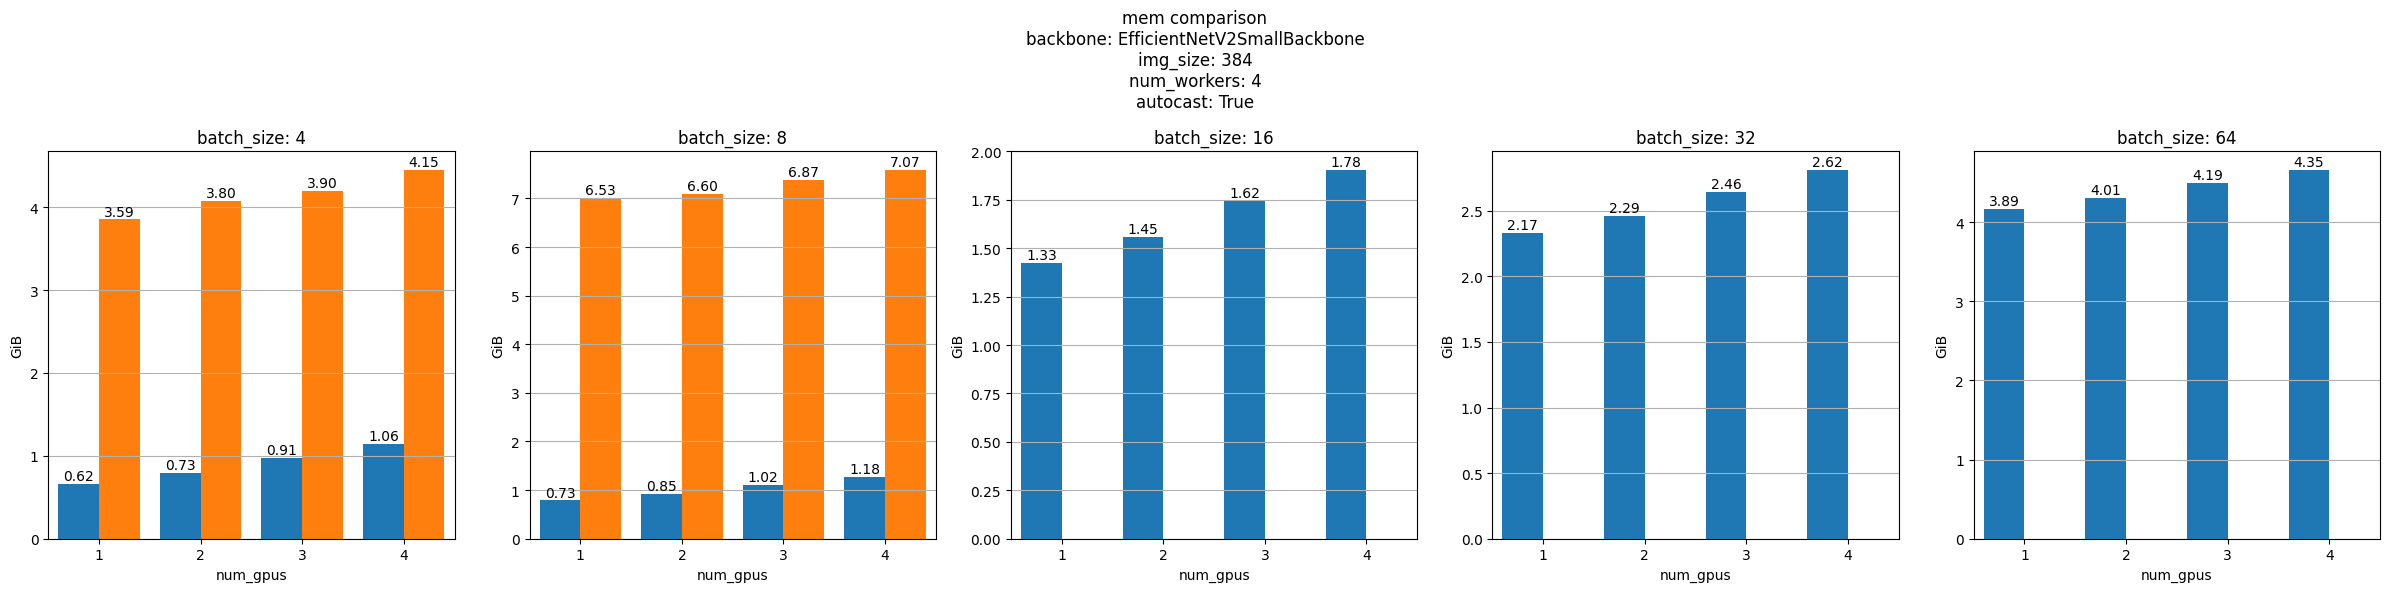

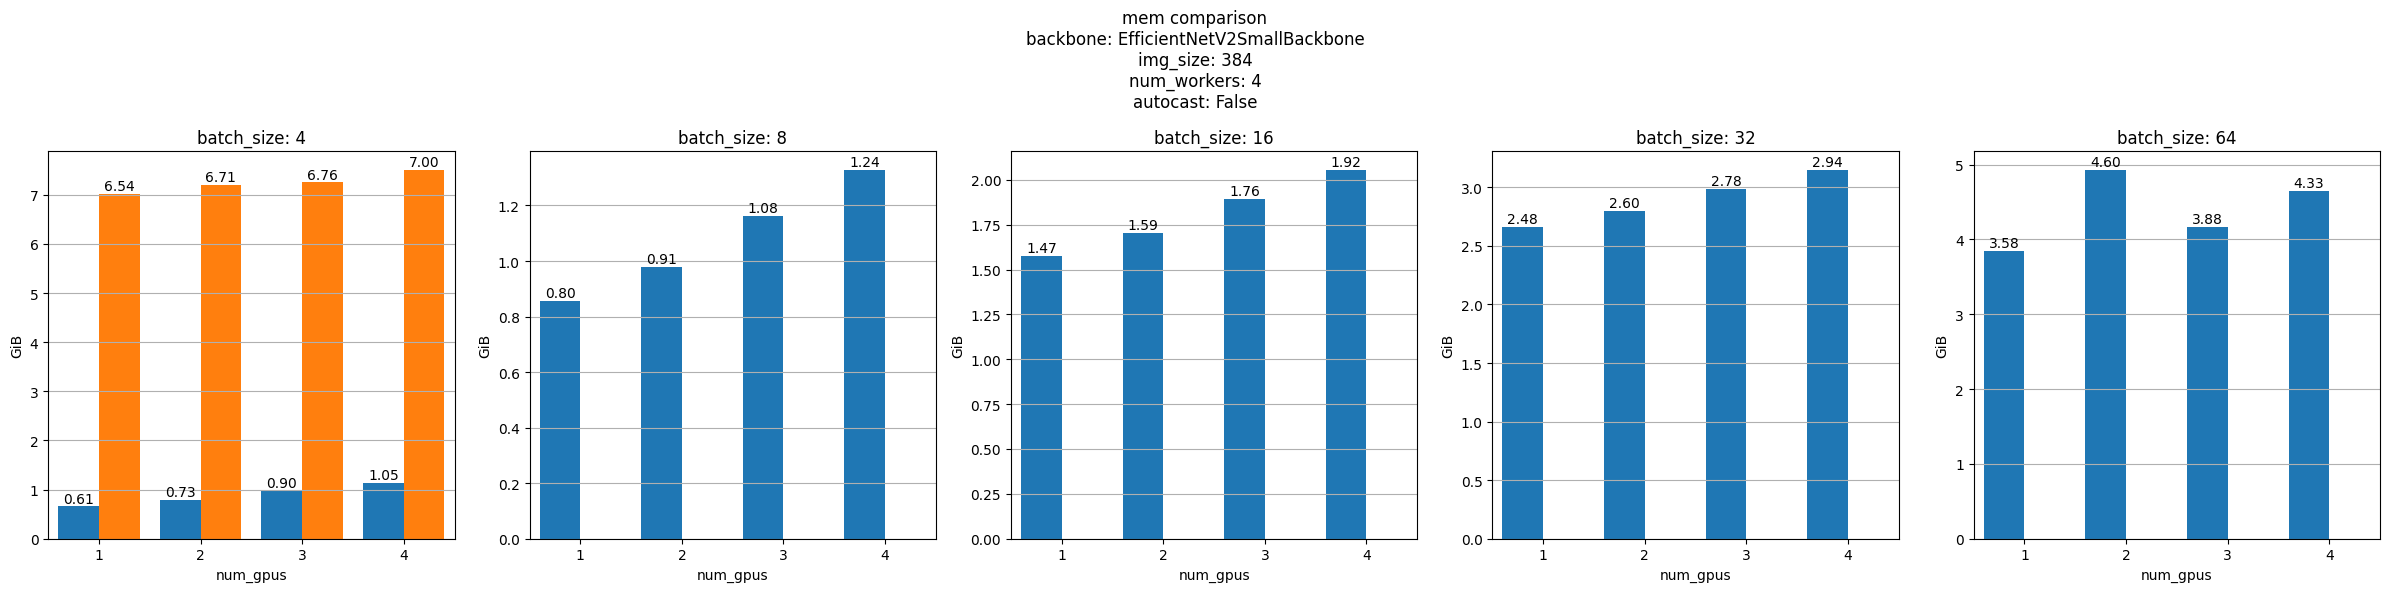

BACKBONE: SwinTransformerV2TinyBackbone


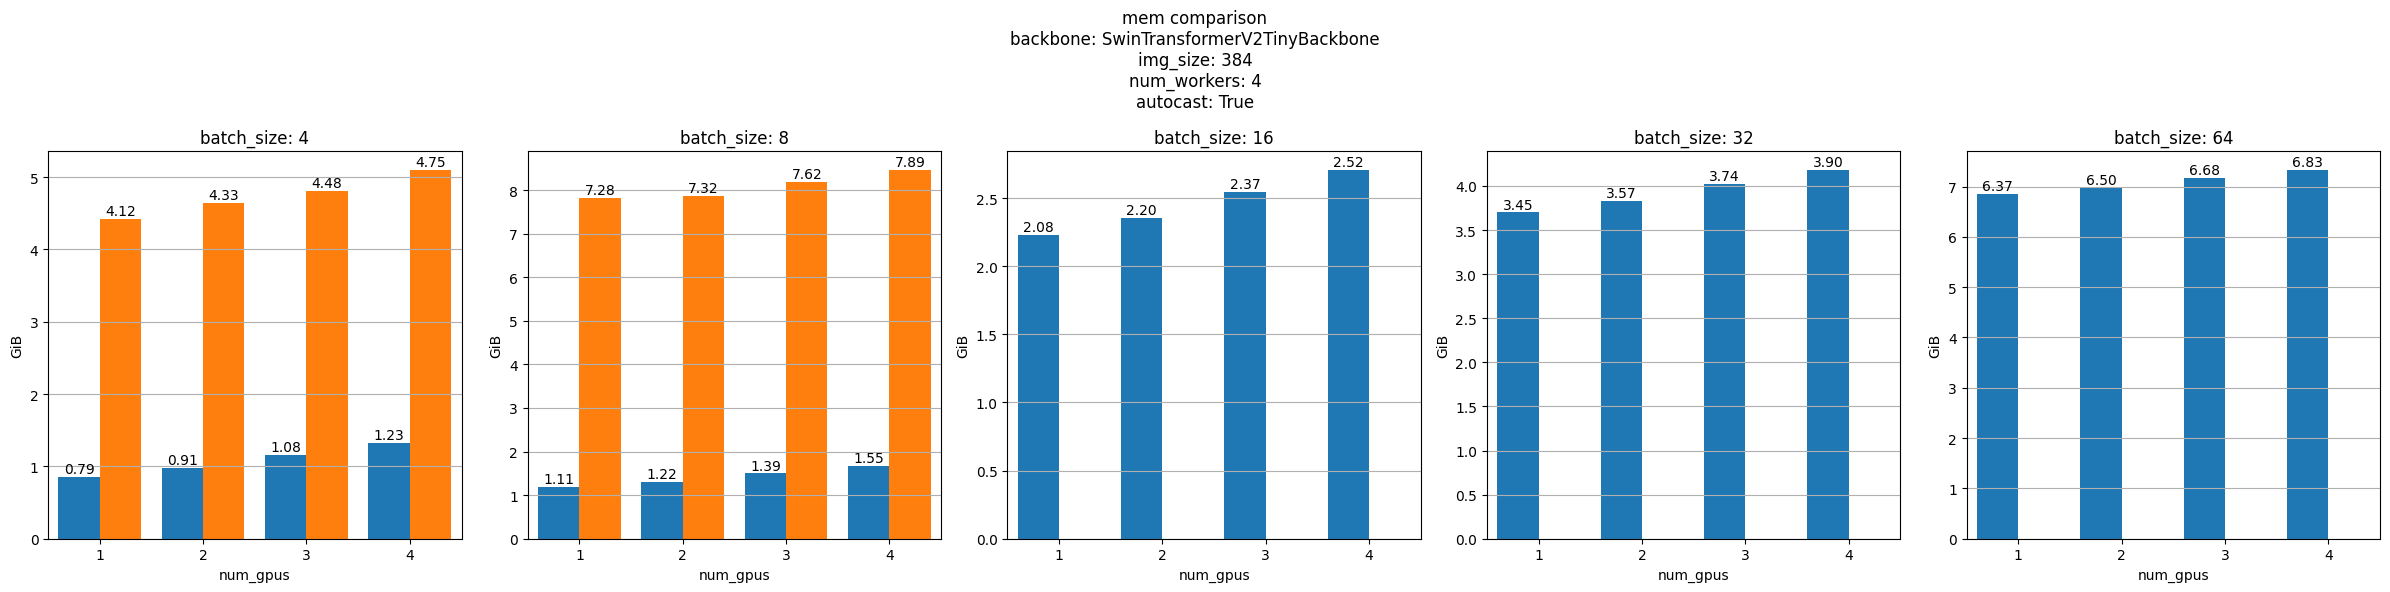

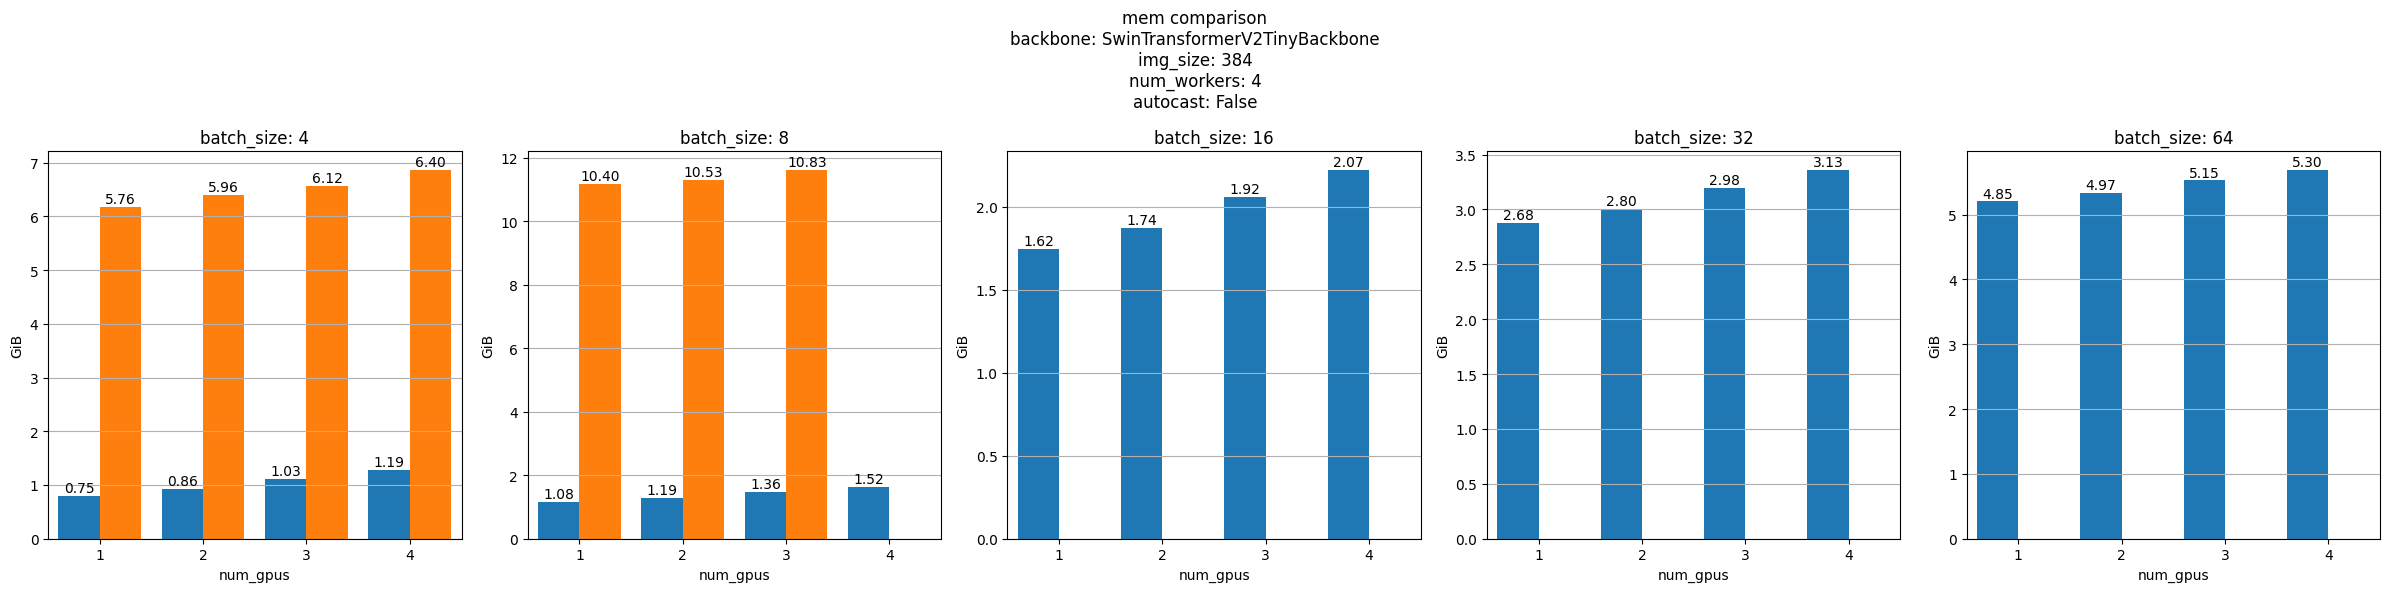

In [15]:
for backbone, in itertools.product(
    list(preview_data_df["backbone"].unique())
):

    print("BACKBONE:", backbone)

    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=384,
        num_workers=4,
        autocast=True,
        metric="mem"
    )
    
    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=384,
        num_workers=4,
        autocast=False,
        metric="mem"
    )

BACKBONE: CvTransformerB21I384D22kBackbone


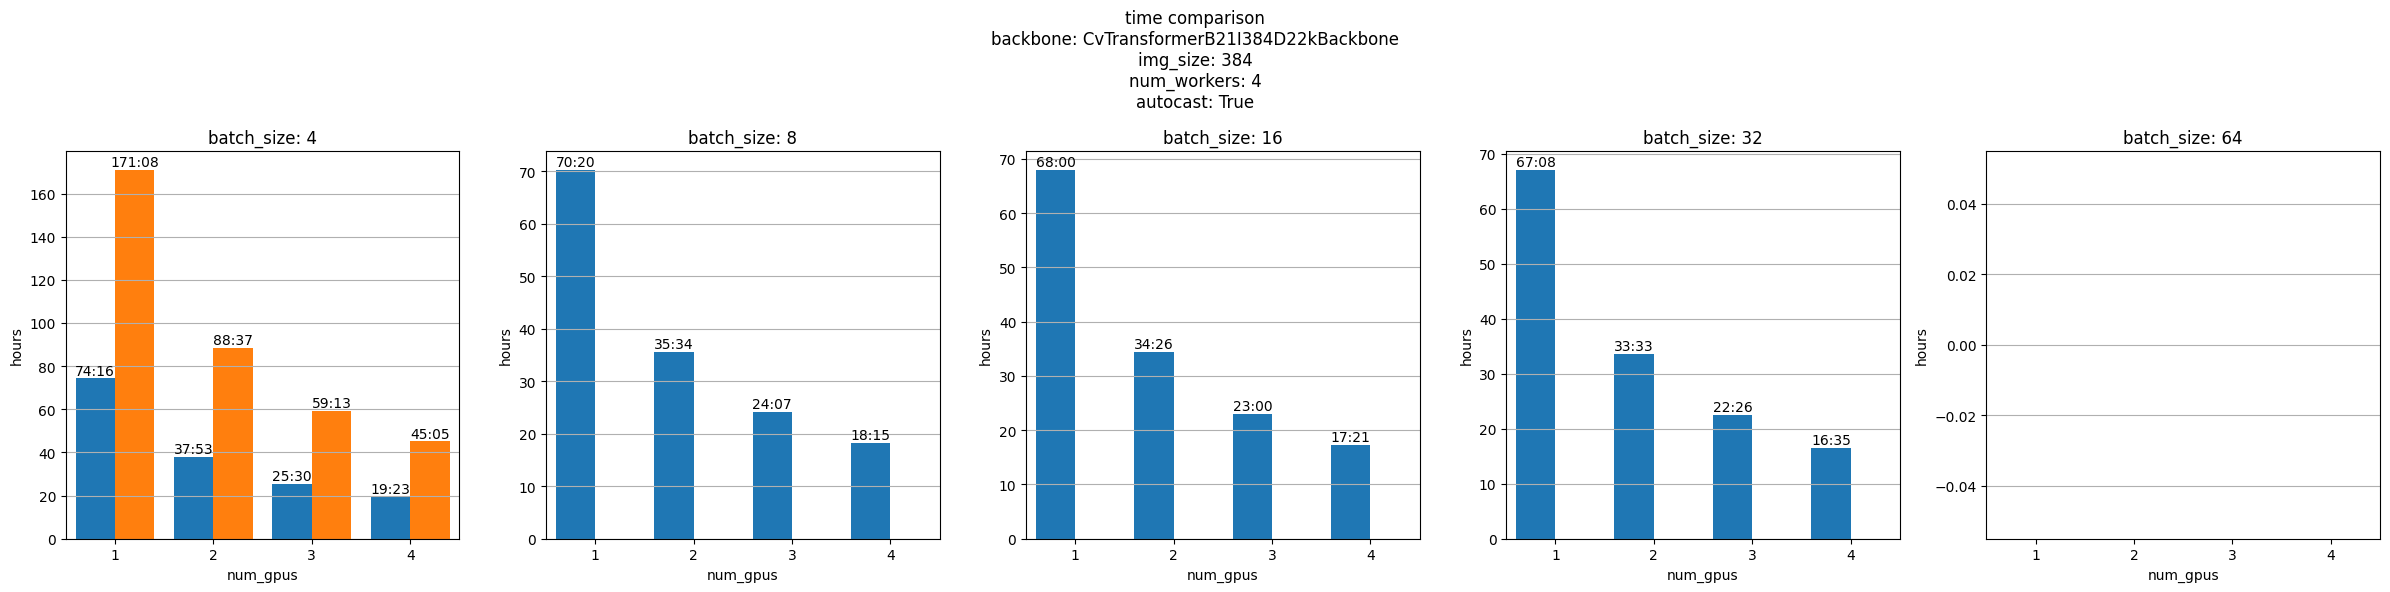

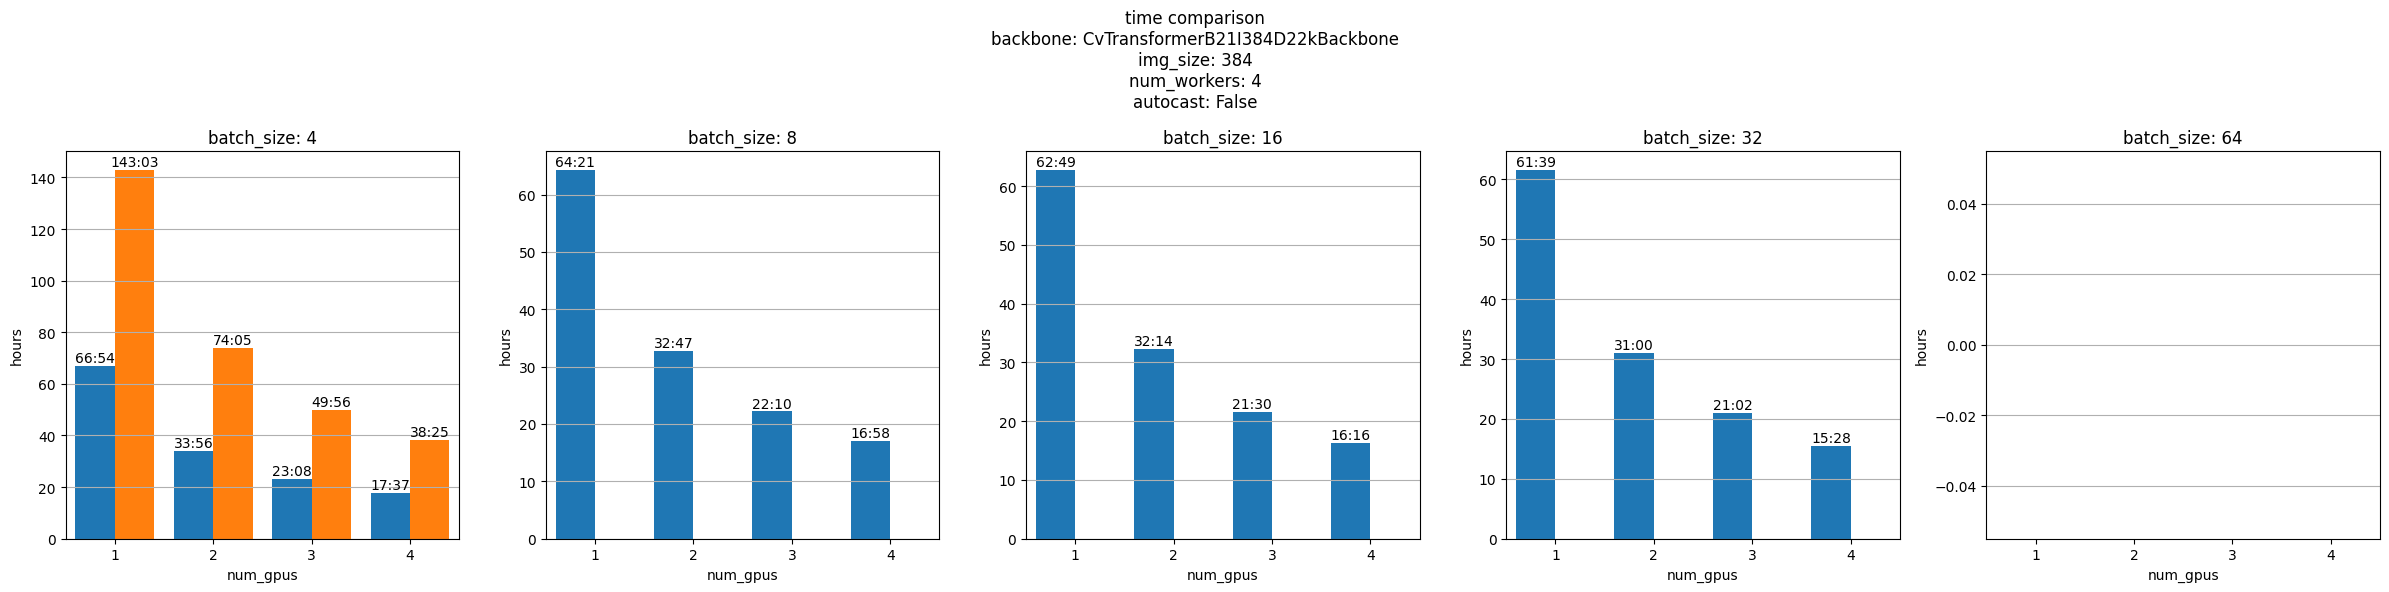

BACKBONE: EfficientNetV2SmallBackbone


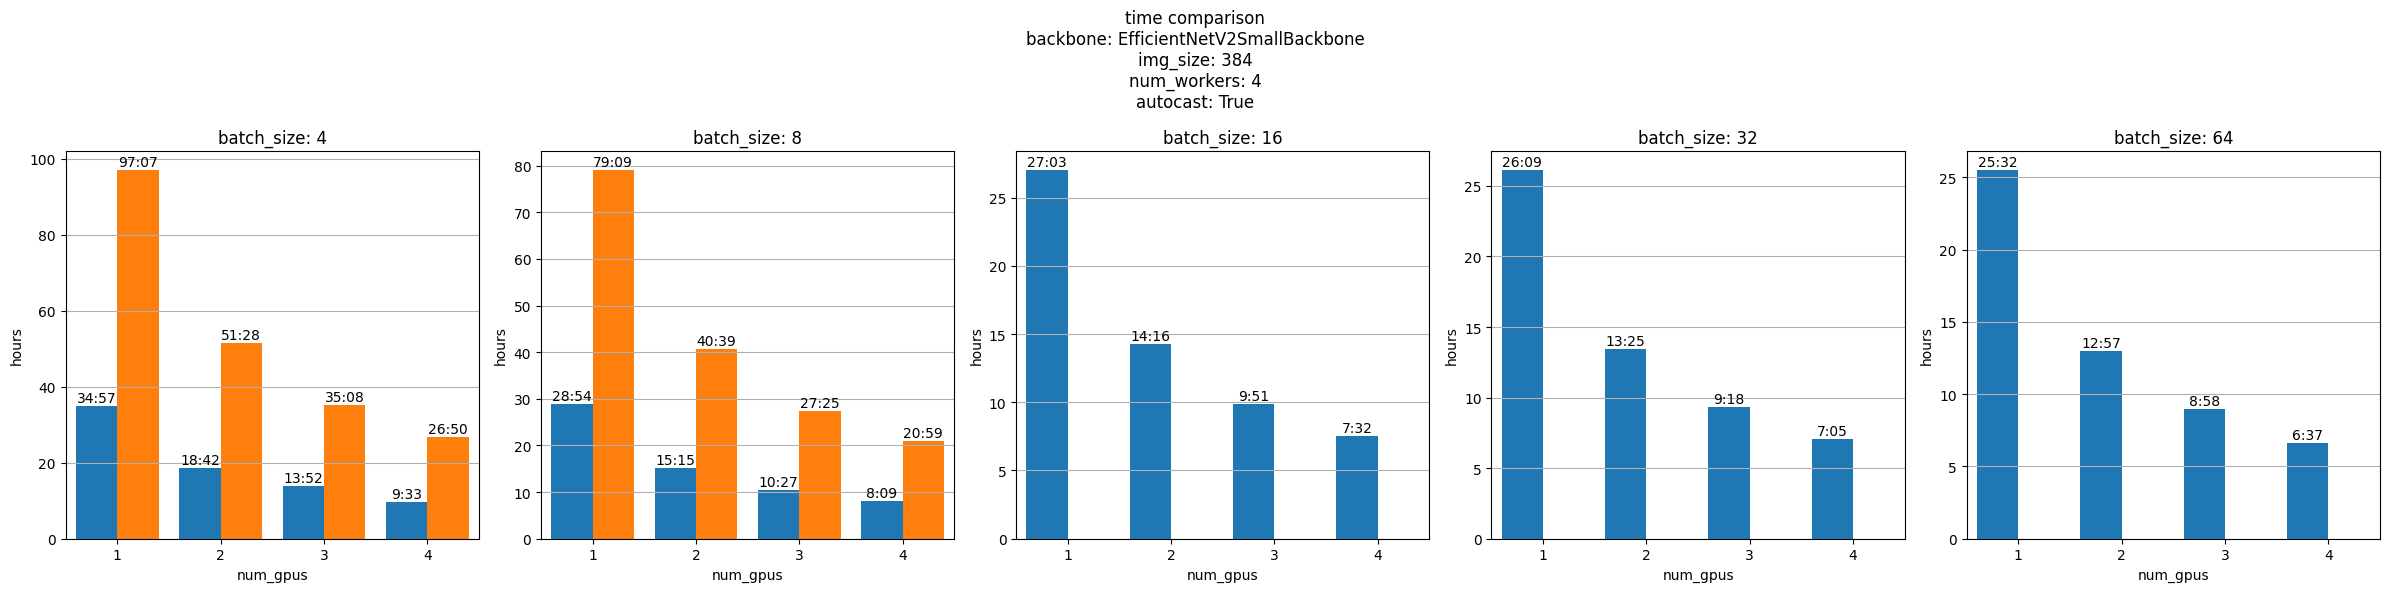

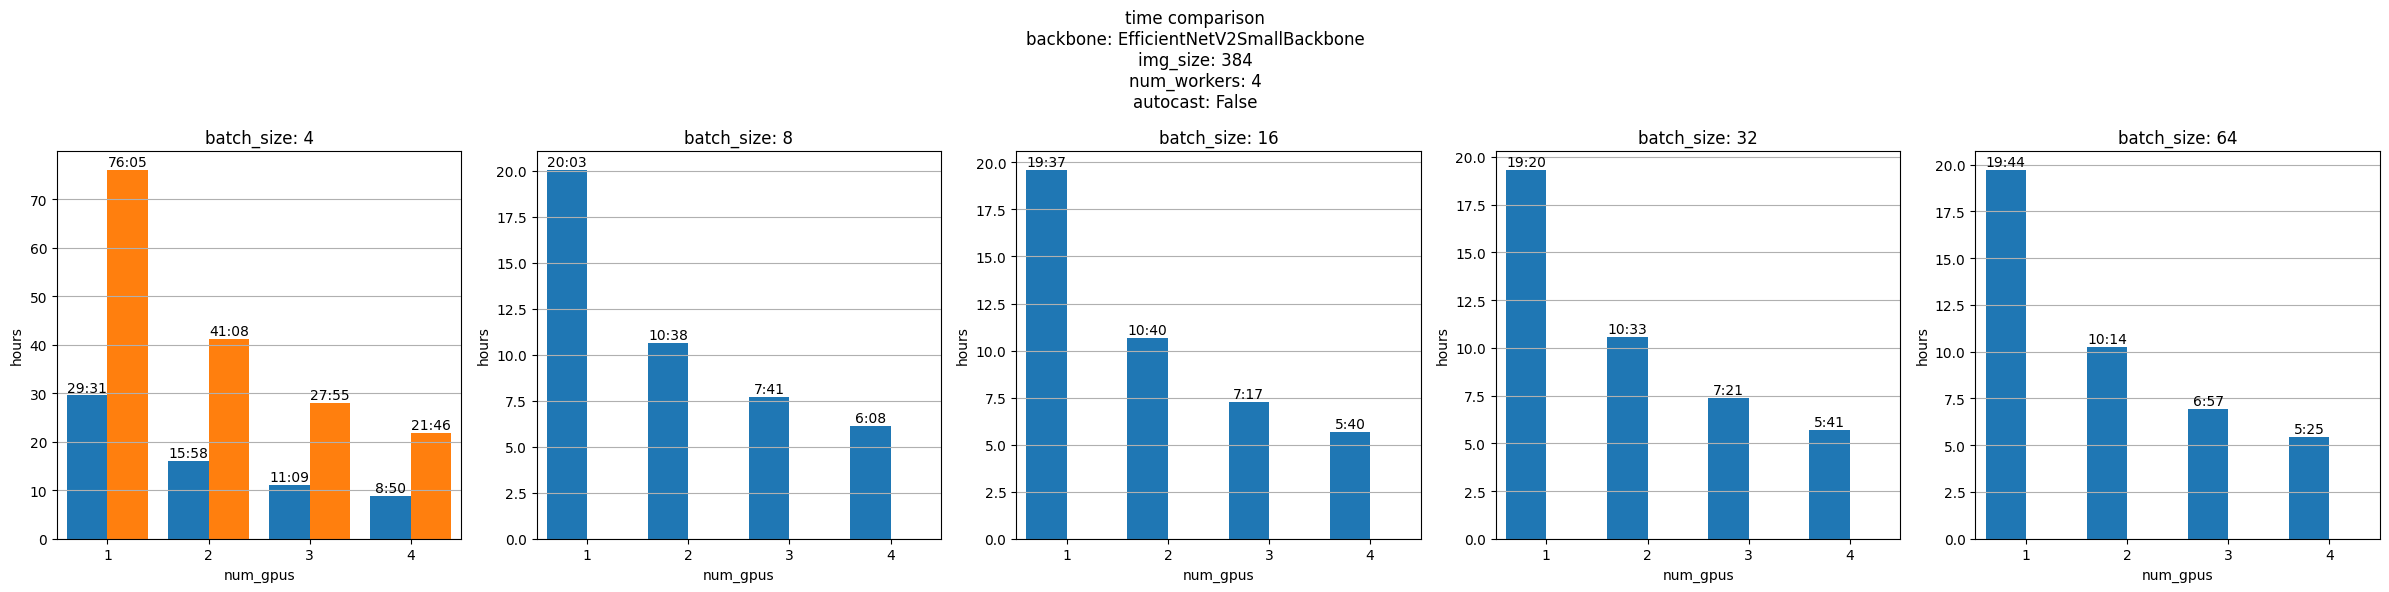

BACKBONE: SwinTransformerV2TinyBackbone


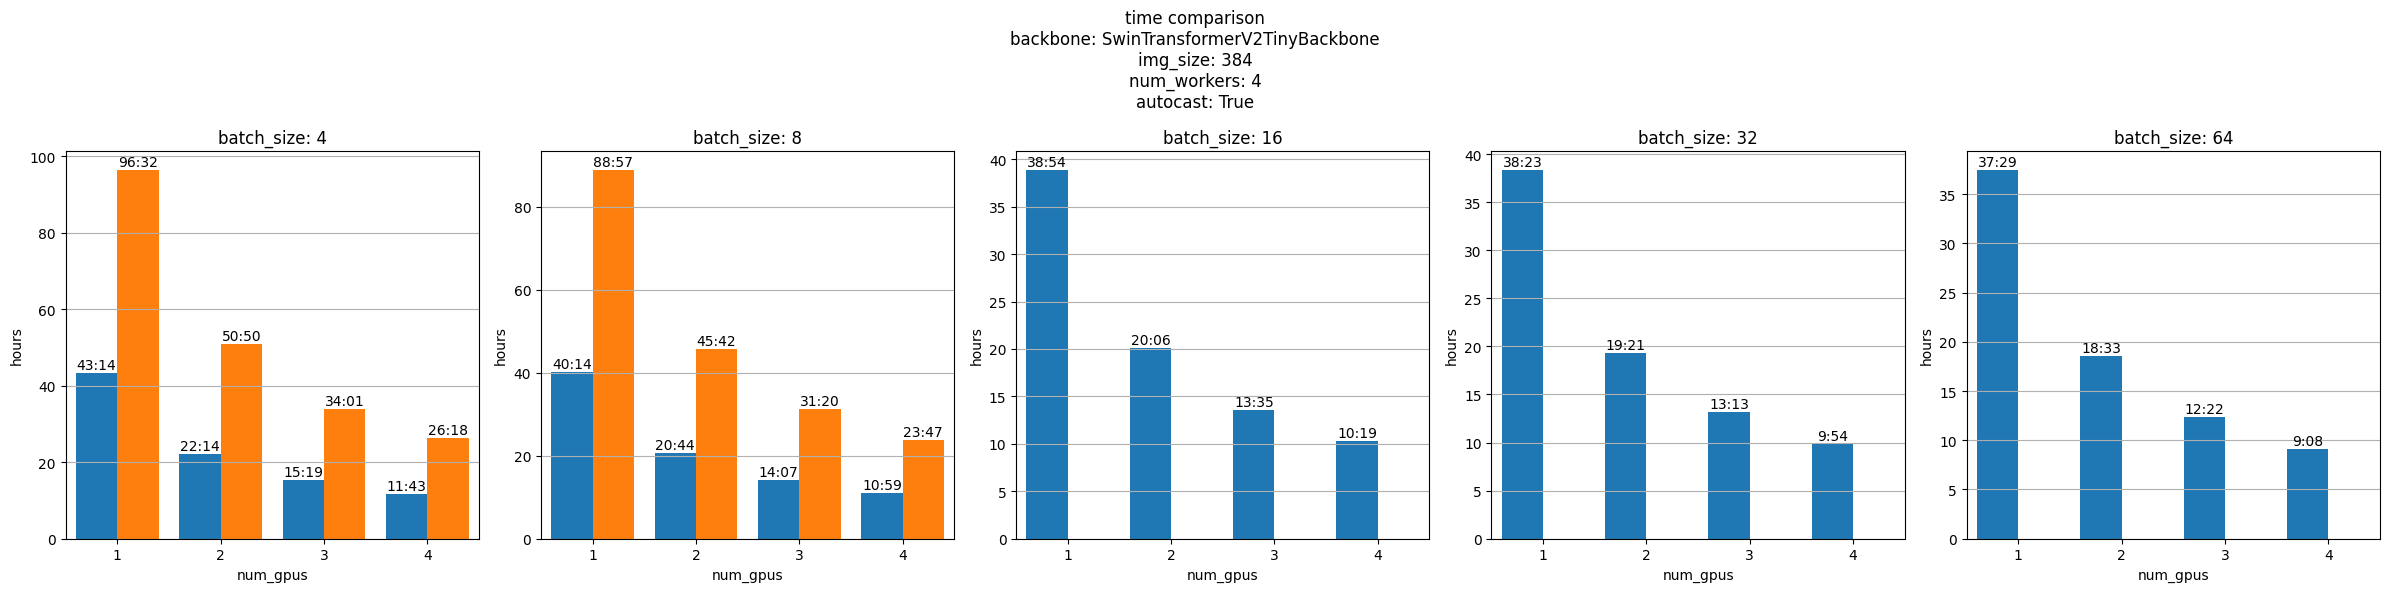

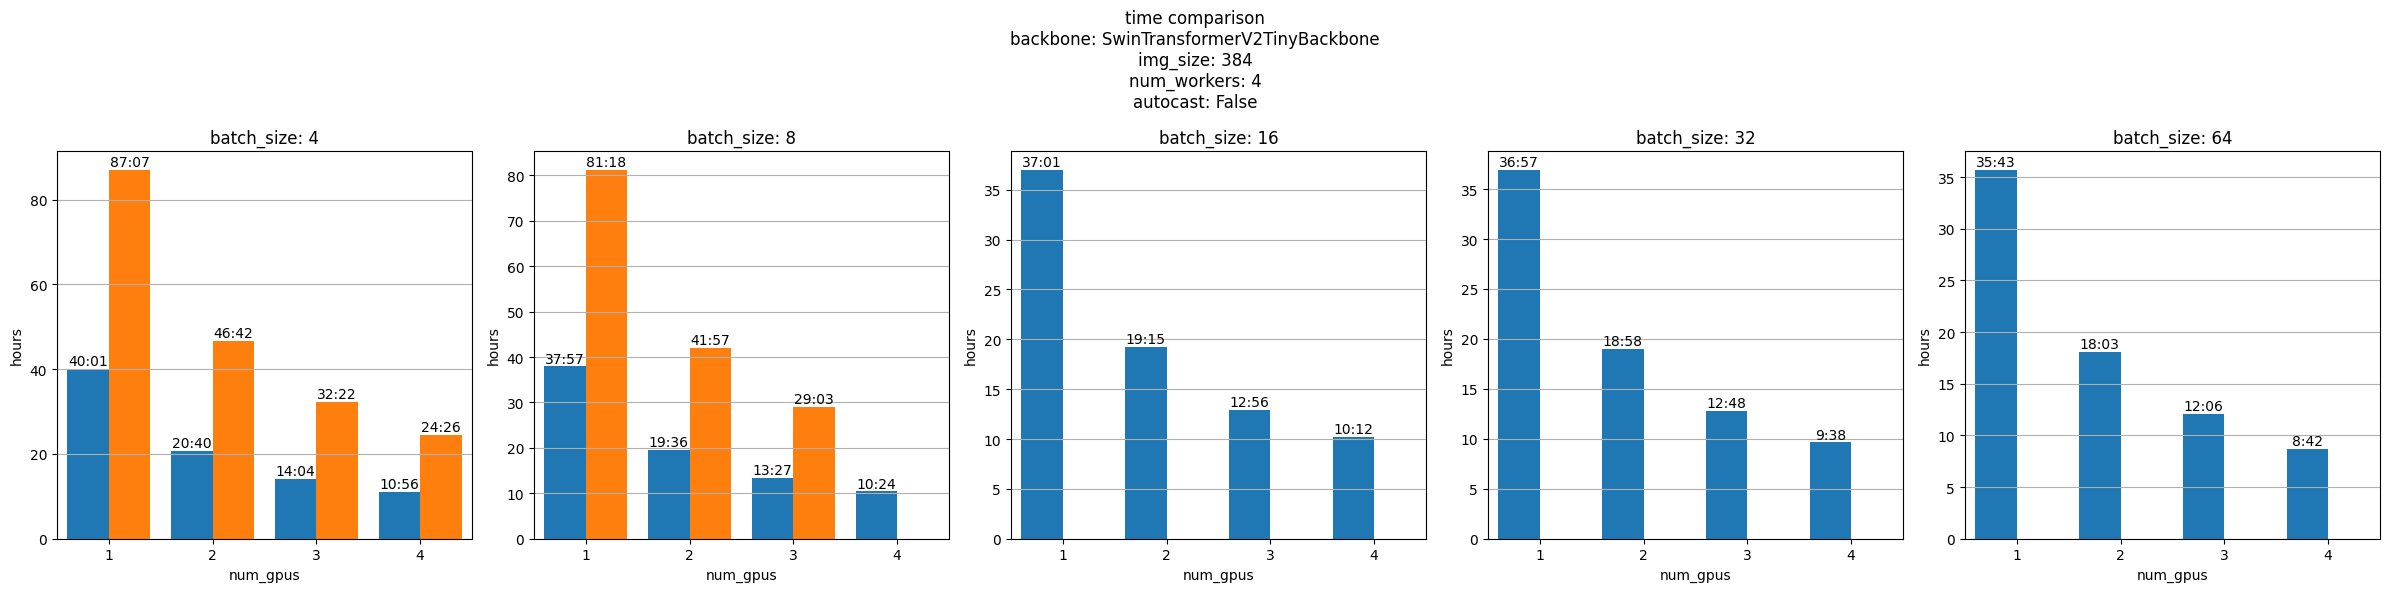

In [16]:
for backbone, in itertools.product(
    list(preview_data_df["backbone"].unique())
):

    print("BACKBONE:", backbone)

    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=384,
        num_workers=4,
        autocast=True,
        metric="time"
    )
    
    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=384,
        num_workers=4,
        autocast=False,
        metric="time"
    )

---

# Image size: 256px

BACKBONE: CvTransformerB21I384D22kBackbone


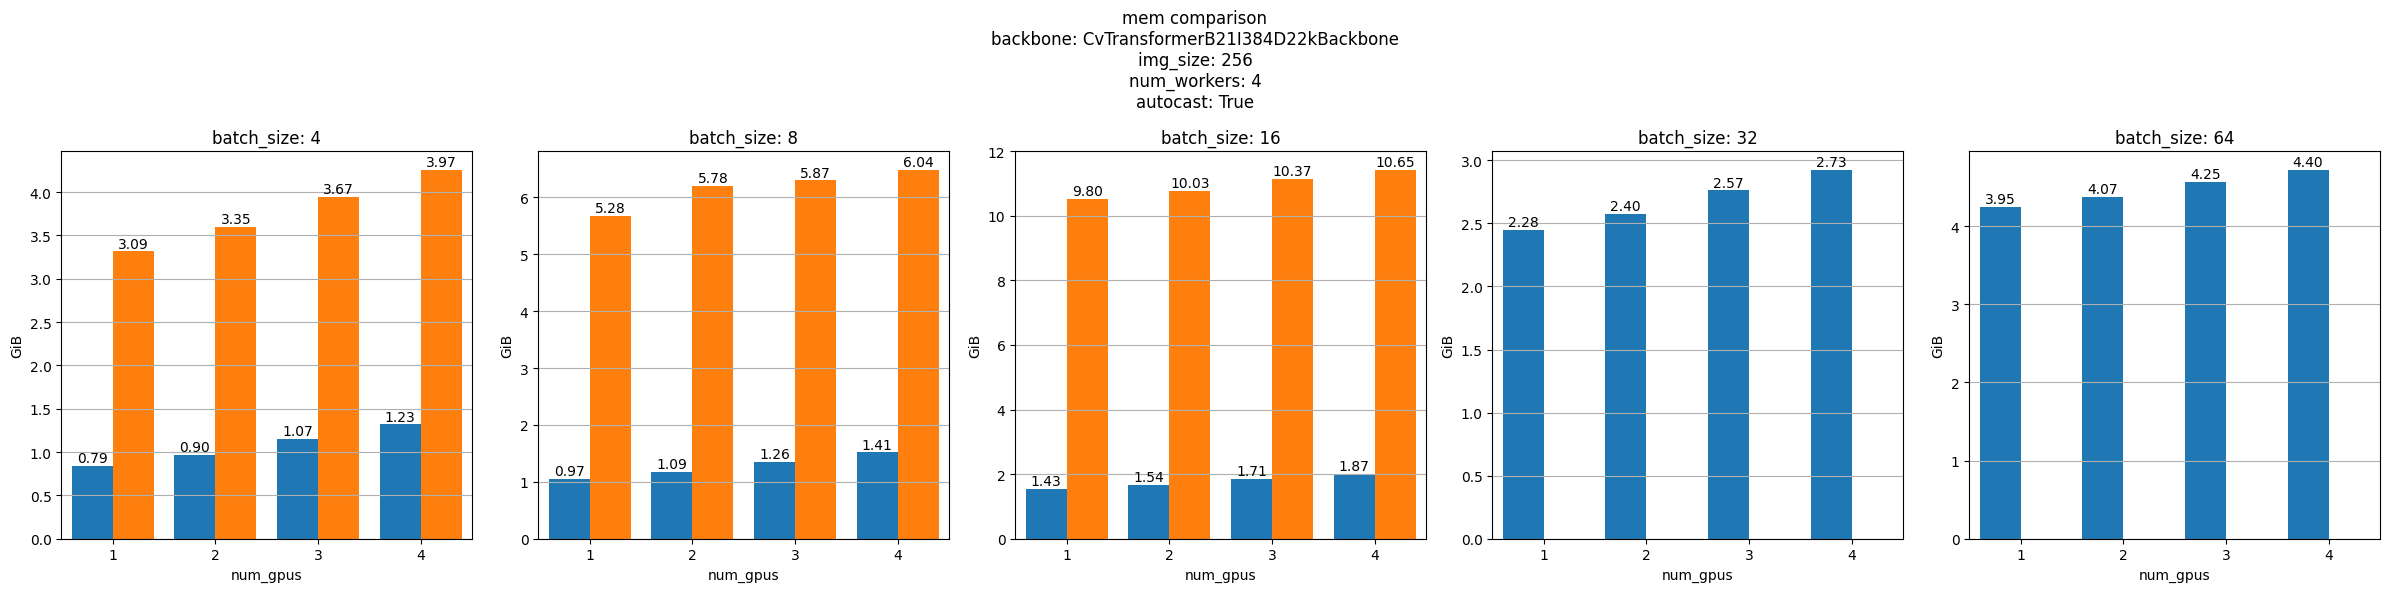

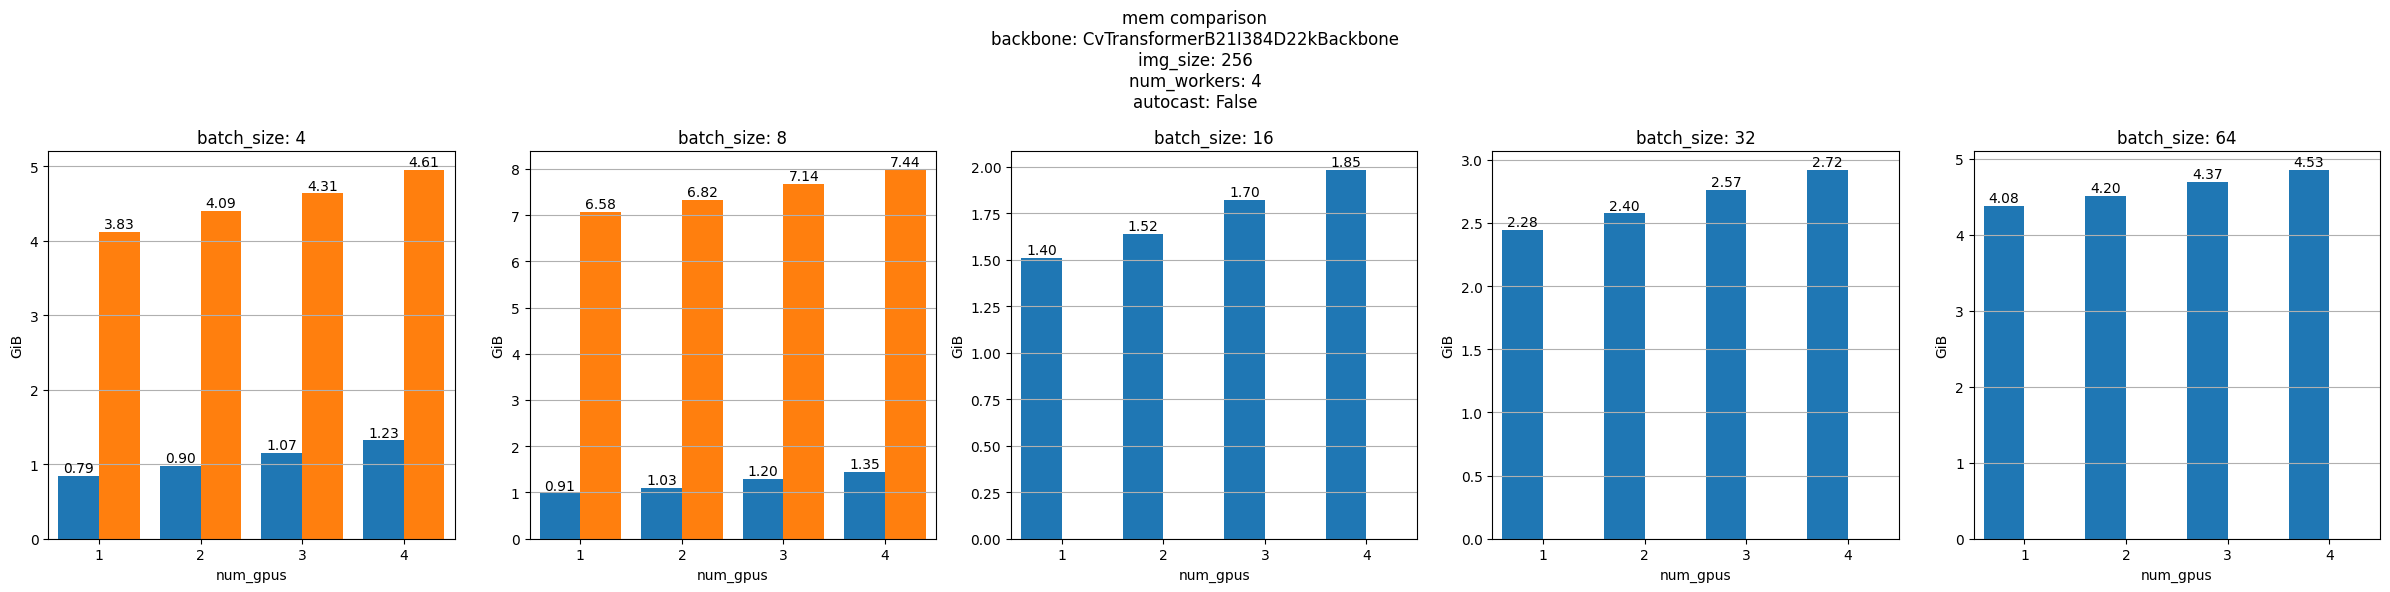

BACKBONE: EfficientNetV2SmallBackbone


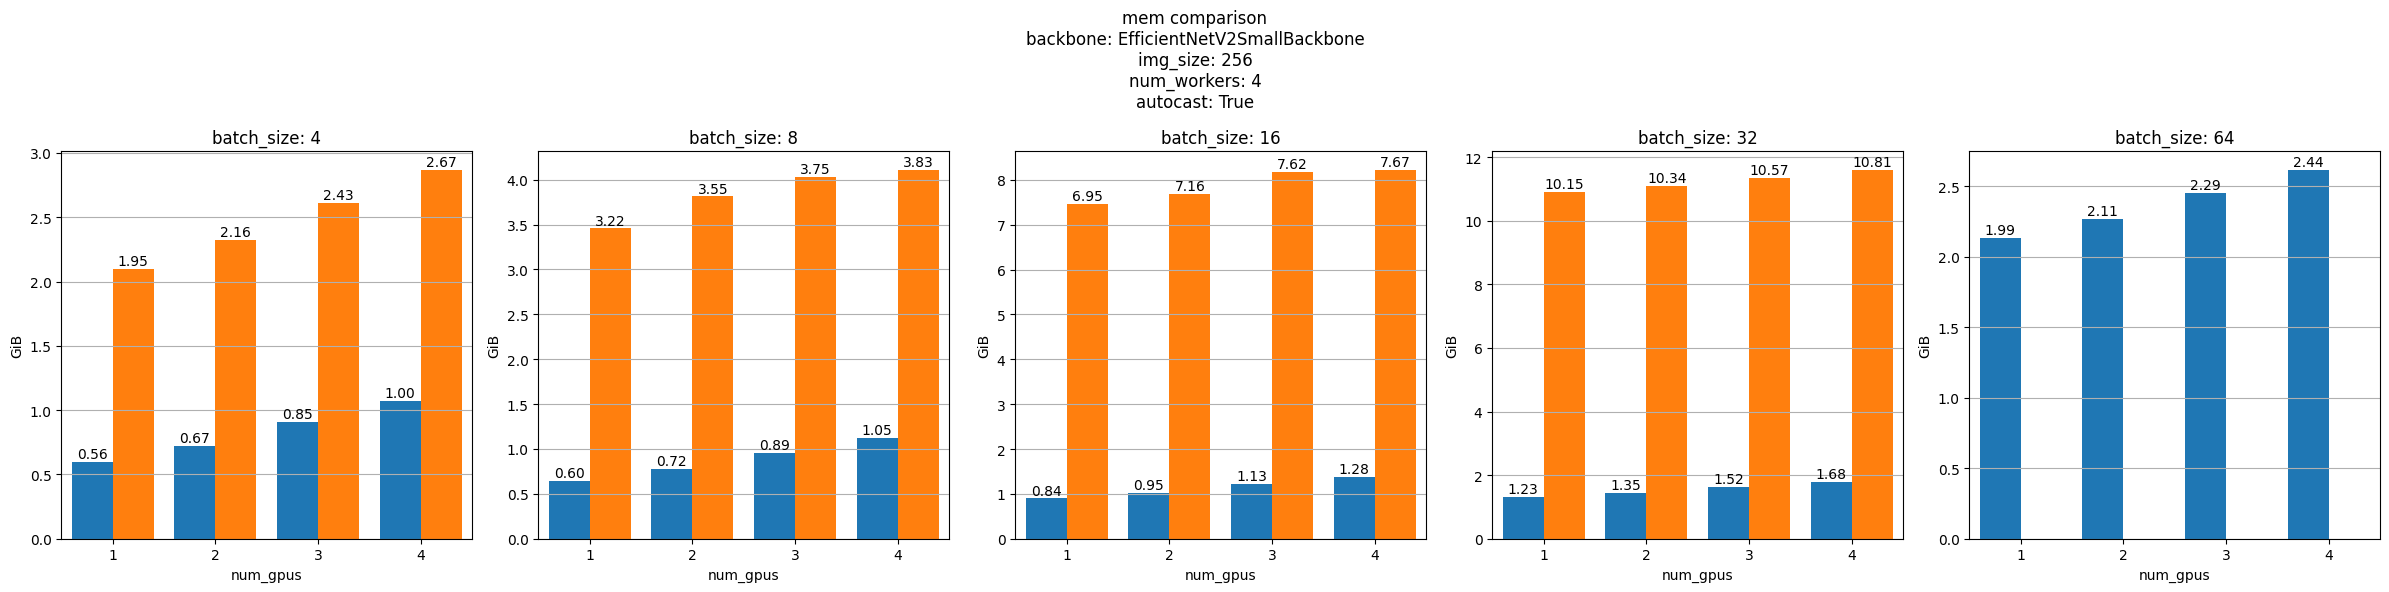

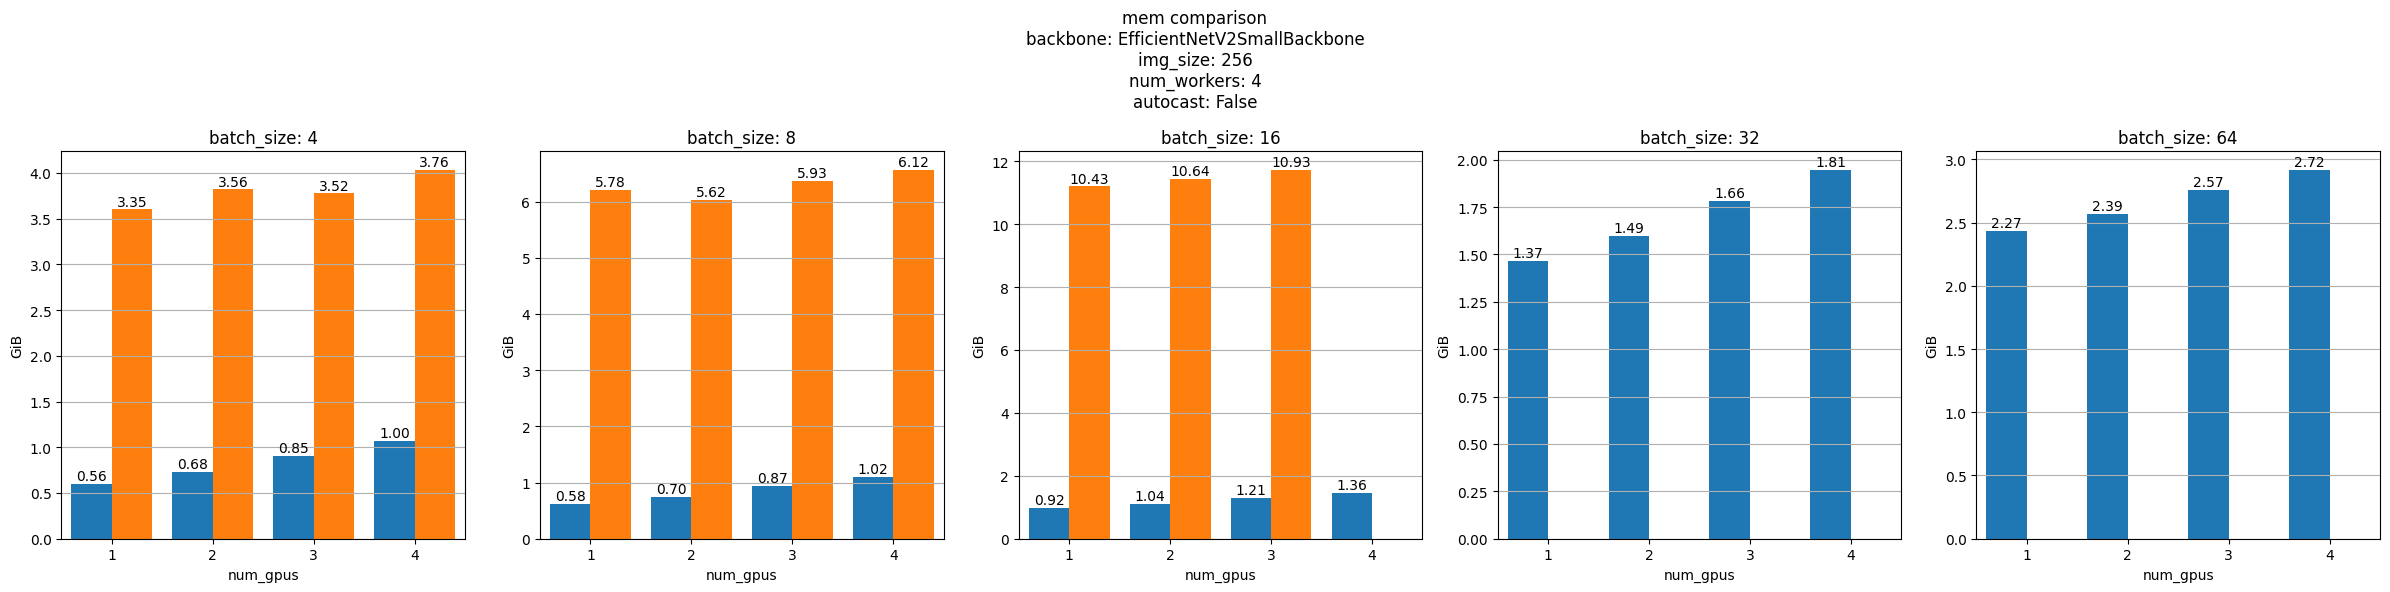

BACKBONE: SwinTransformerV2TinyBackbone


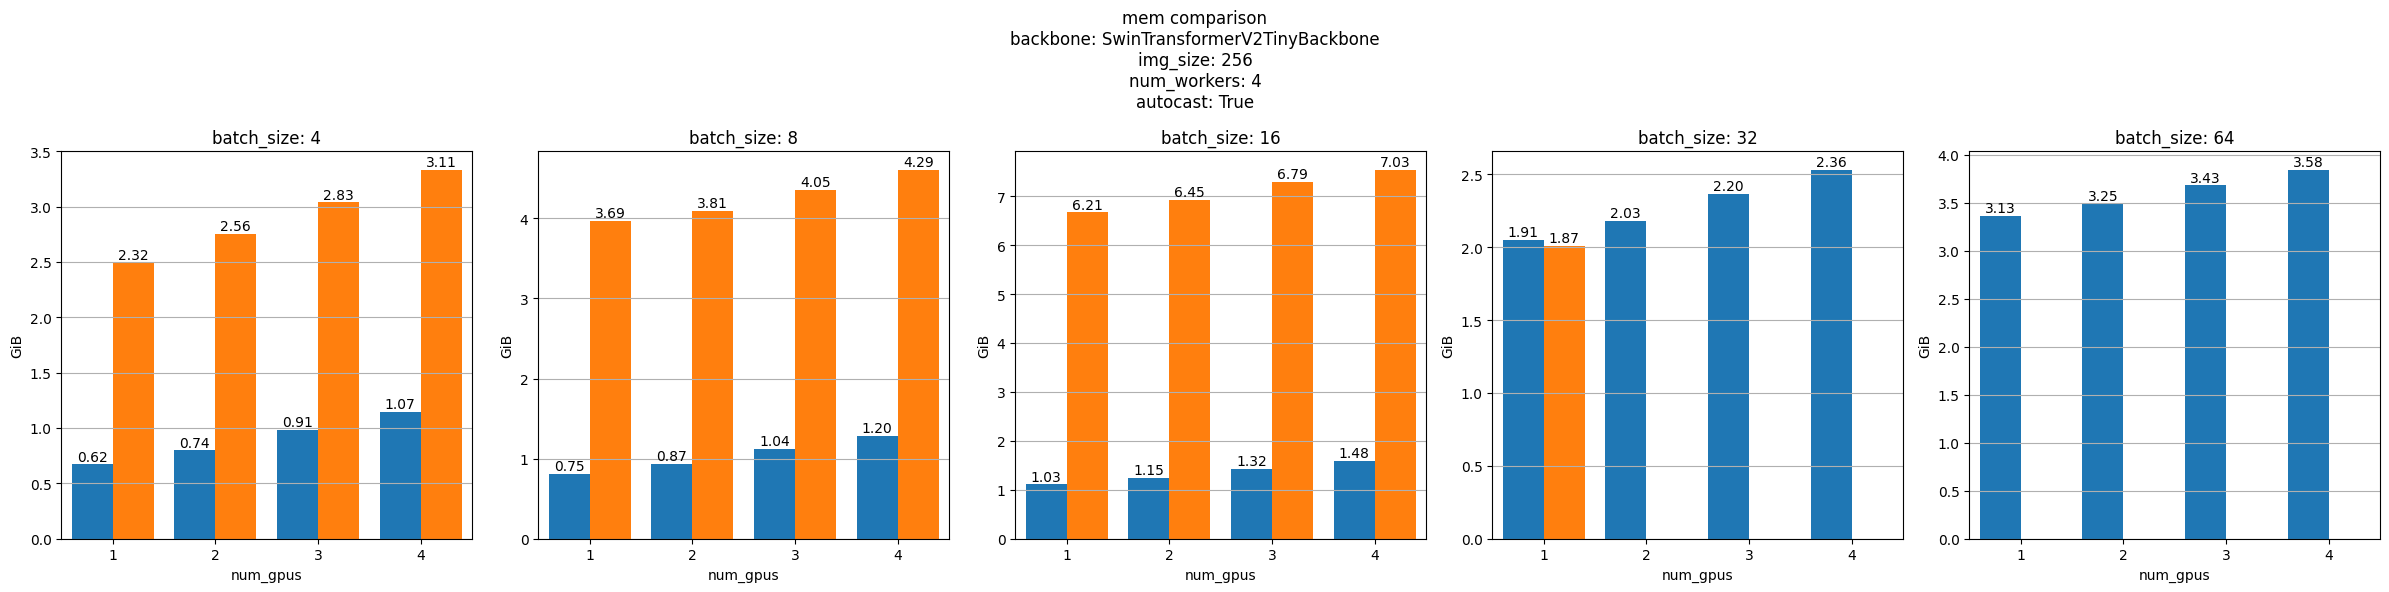

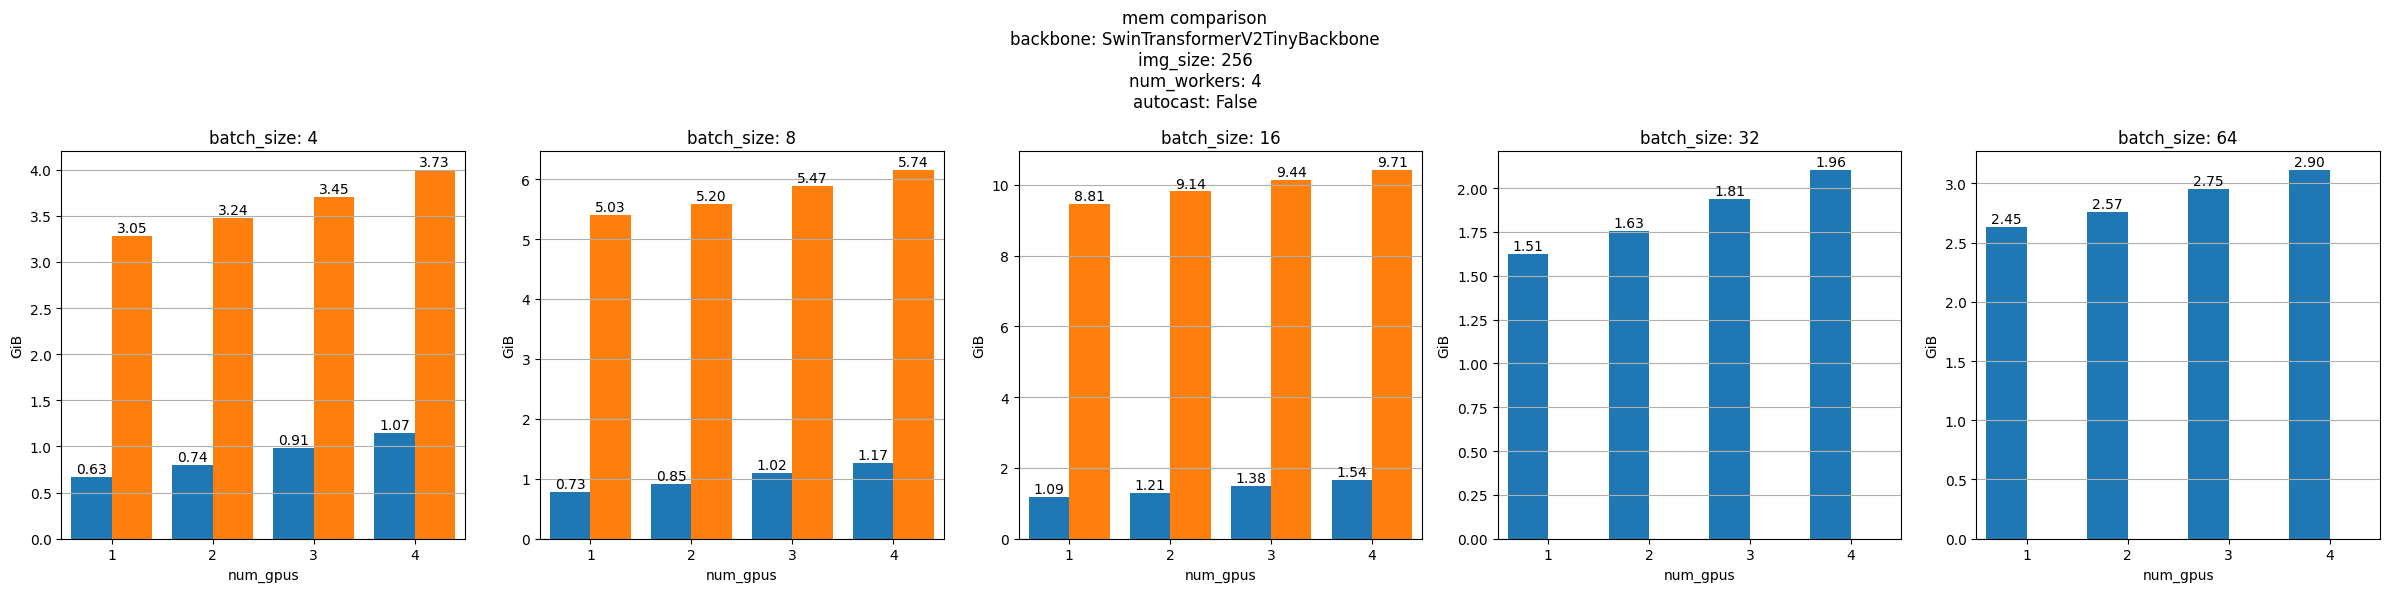

In [11]:
for backbone, in itertools.product(
    list(preview_data_df["backbone"].unique())
):

    print("BACKBONE:", backbone)

    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=256,
        num_workers=4,
        autocast=True,
        metric="mem"
    )
    
    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=256,
        num_workers=4,
        autocast=False,
        metric="mem"
    )

BACKBONE: CvTransformerB21I384D22kBackbone


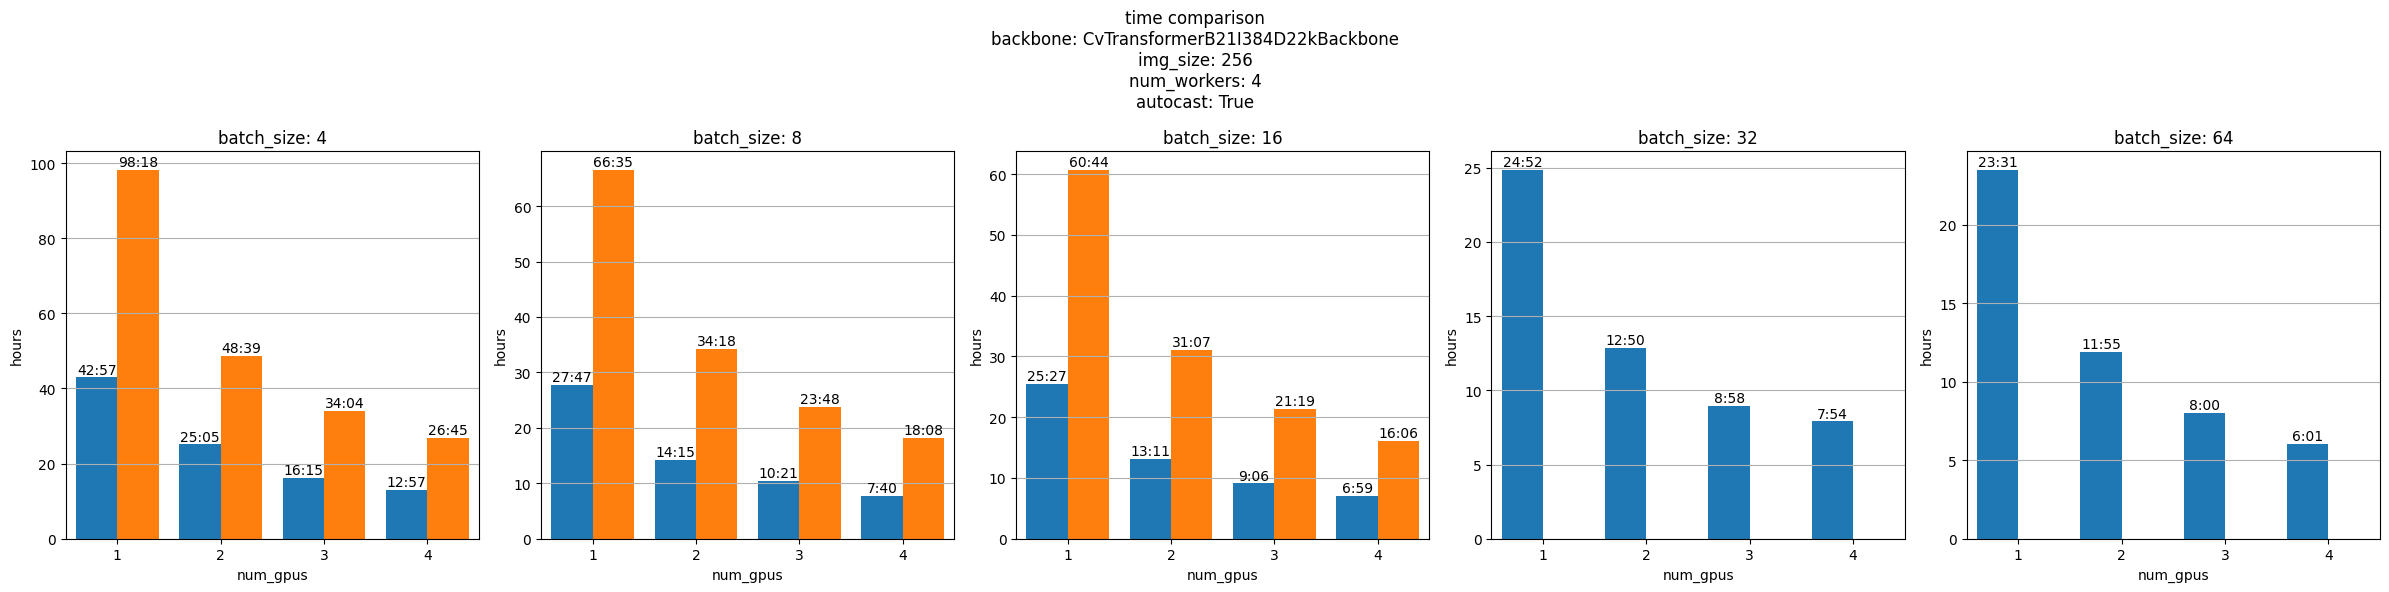

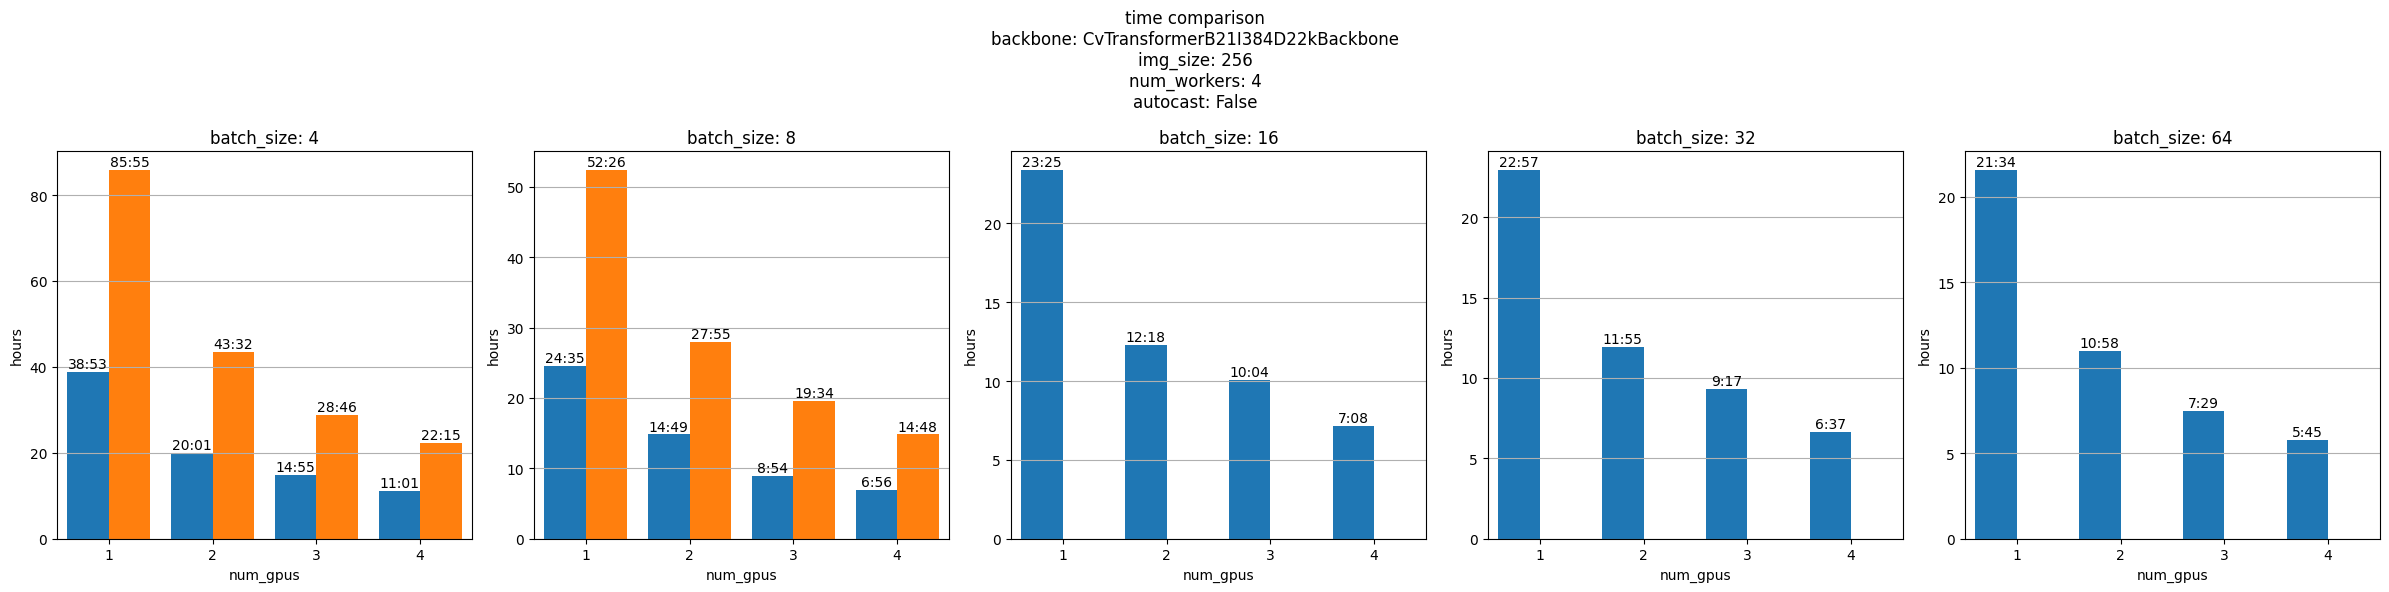

BACKBONE: EfficientNetV2SmallBackbone


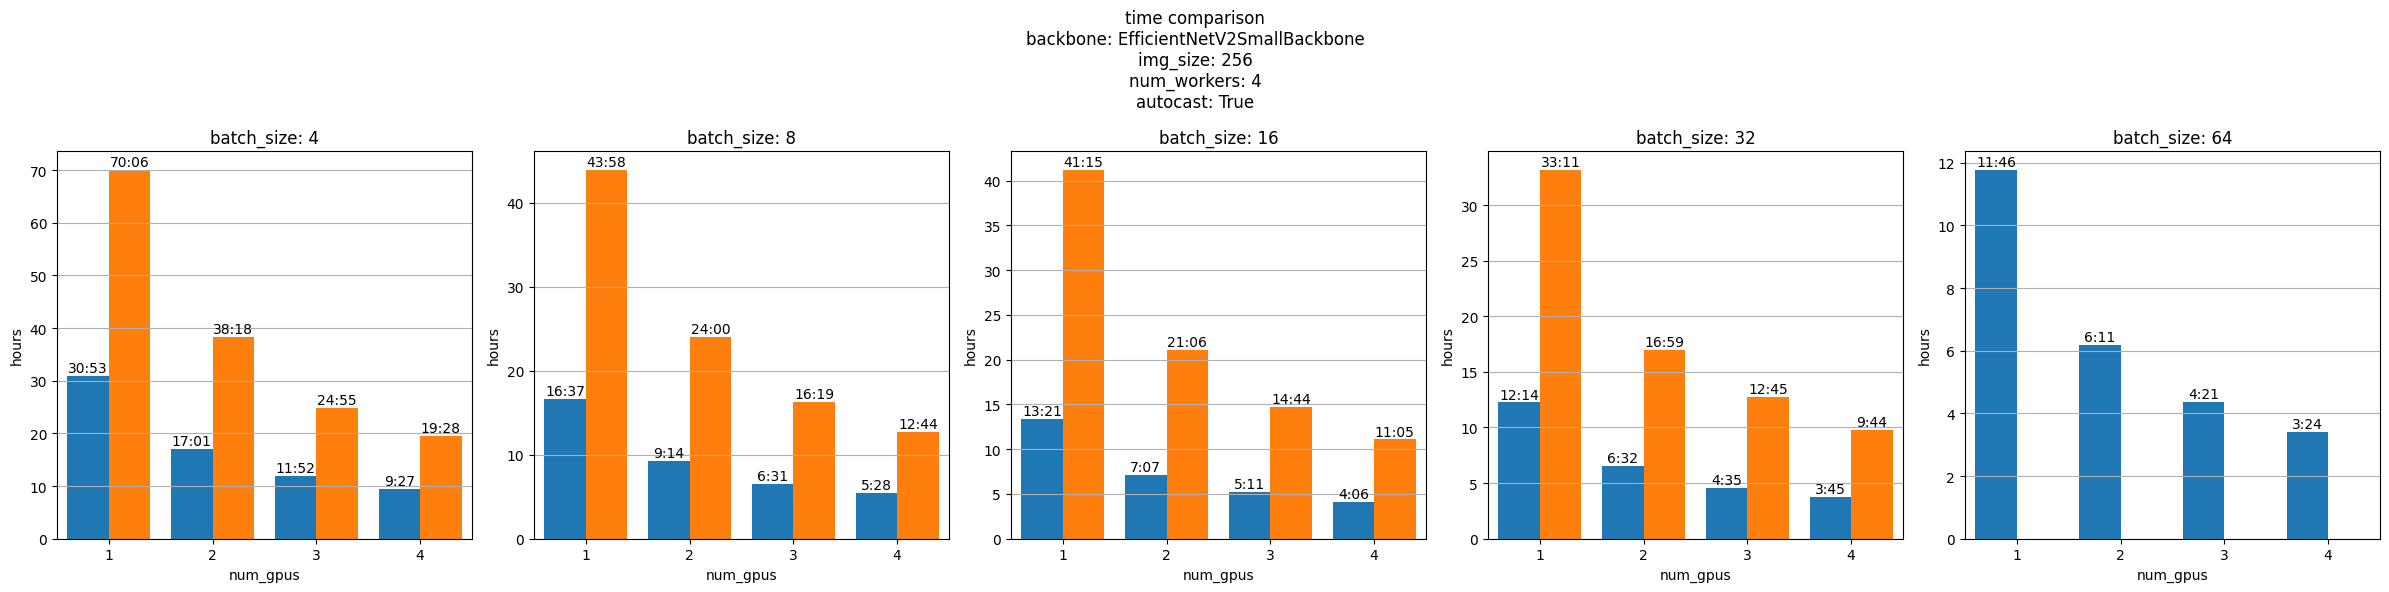

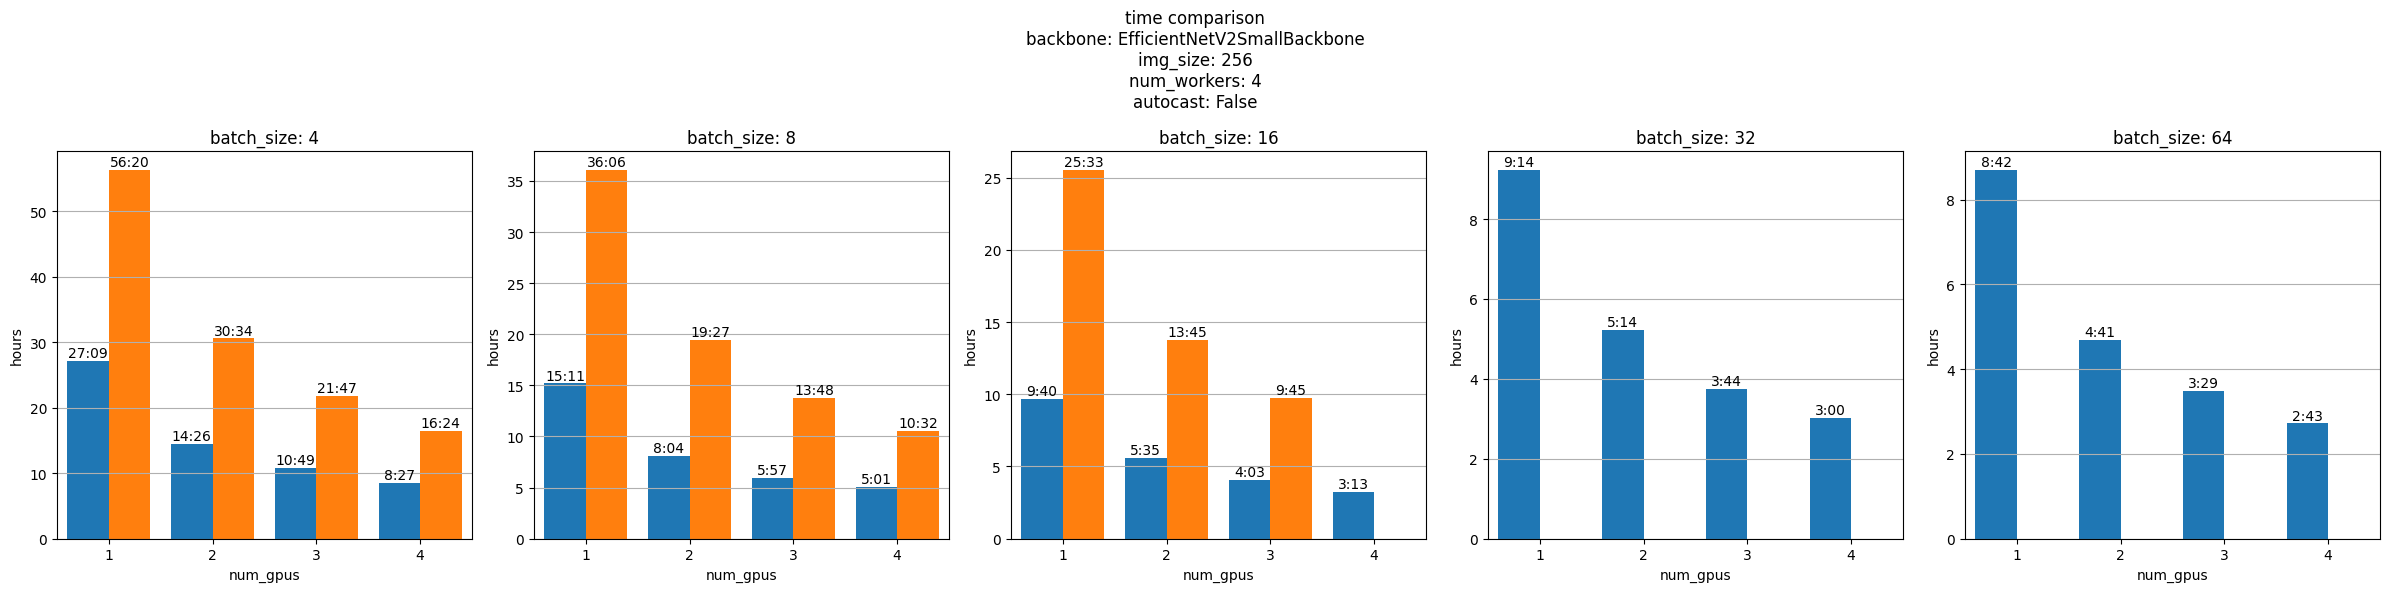

BACKBONE: SwinTransformerV2TinyBackbone


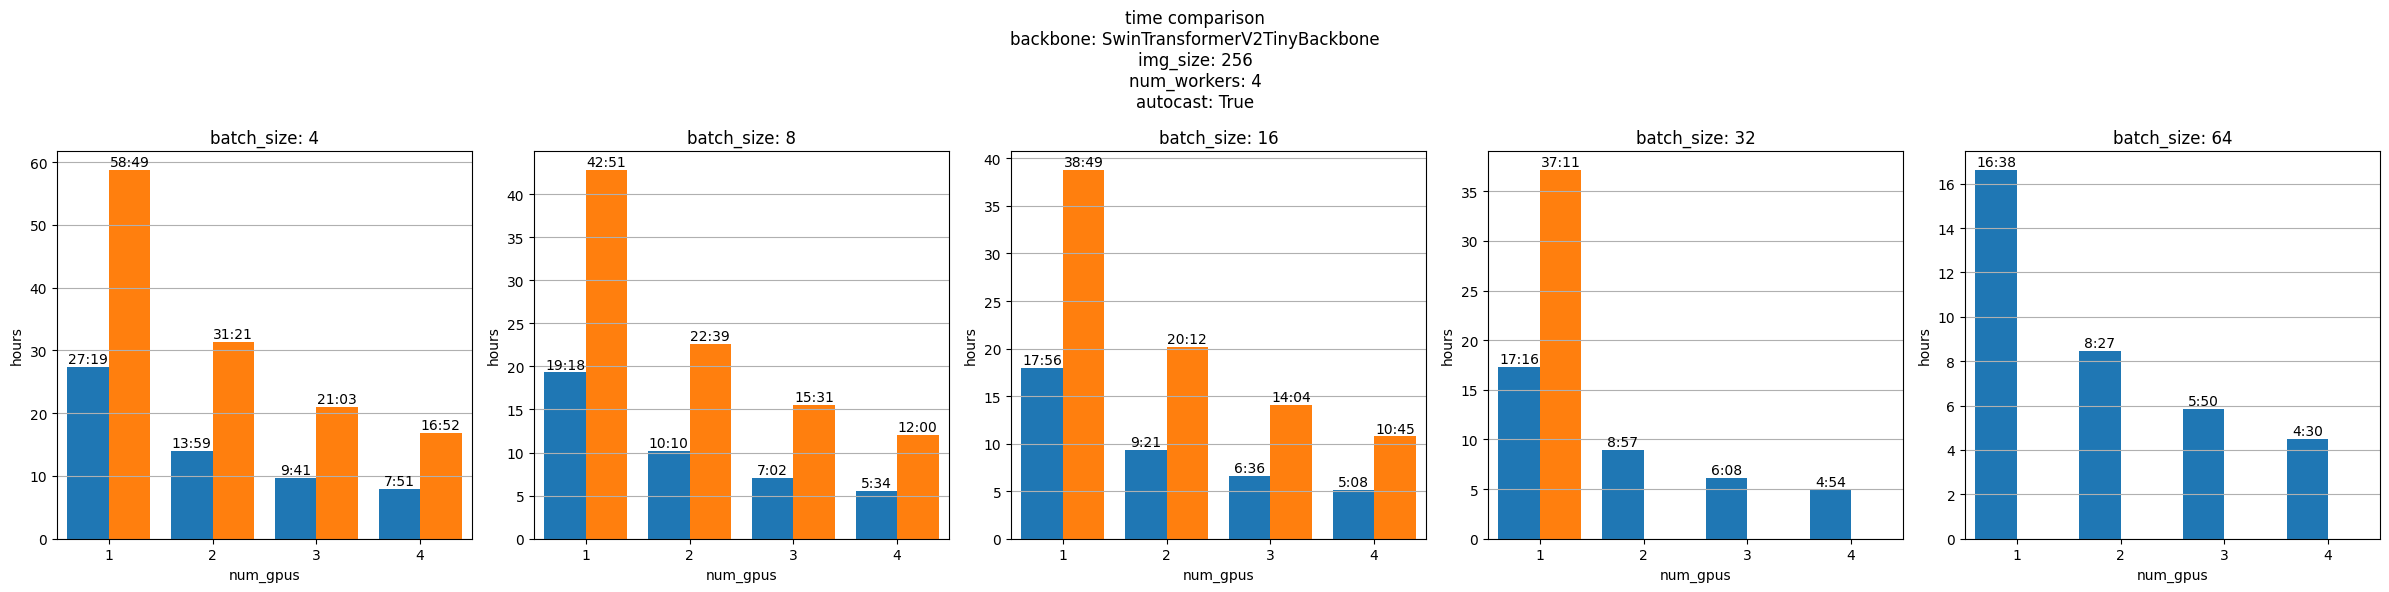

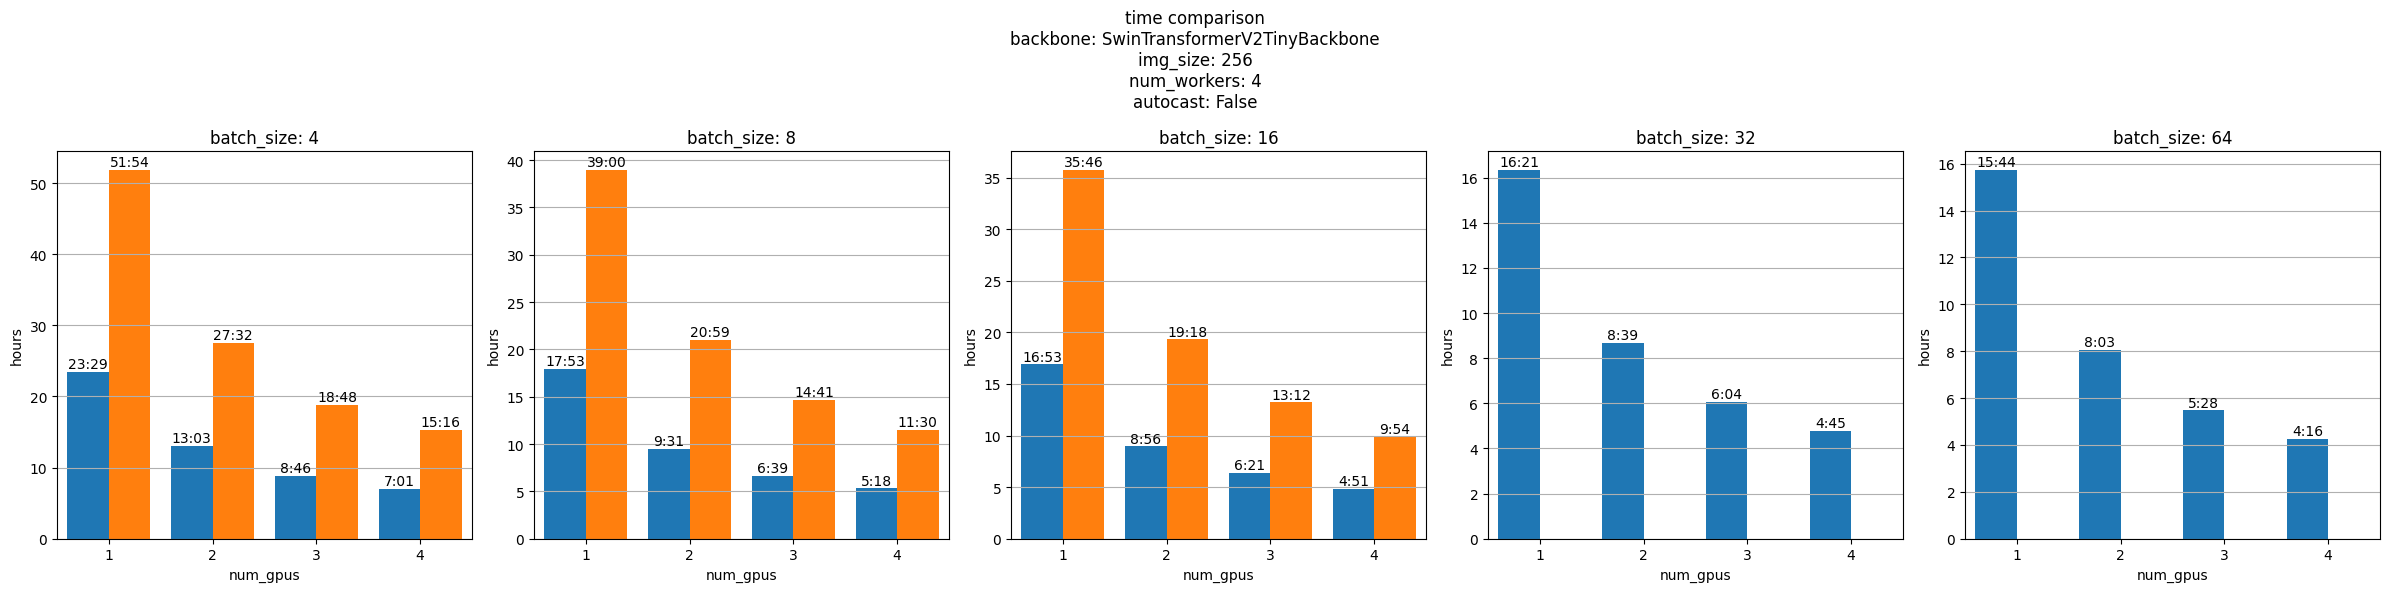

In [12]:
for backbone, in itertools.product(
    list(preview_data_df["backbone"].unique())
):

    print("BACKBONE:", backbone)

    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=256,
        num_workers=4,
        autocast=True,
        metric="time"
    )
    
    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=256,
        num_workers=4,
        autocast=False,
        metric="time"
    )

---

BACKBONE: CvTransformerB21I384D22kBackbone


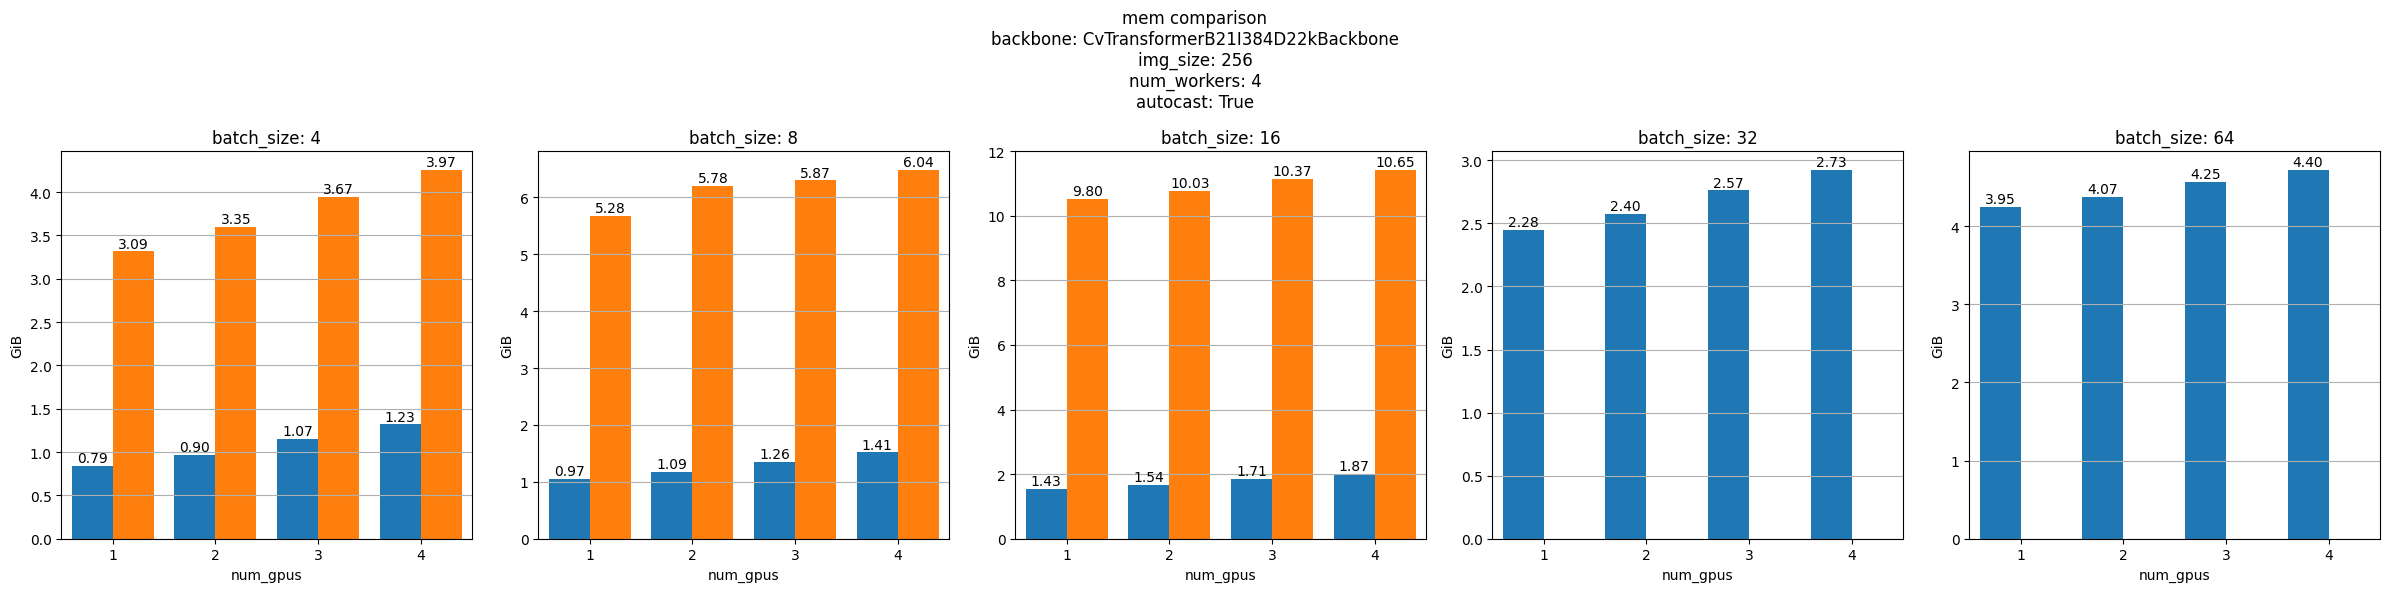

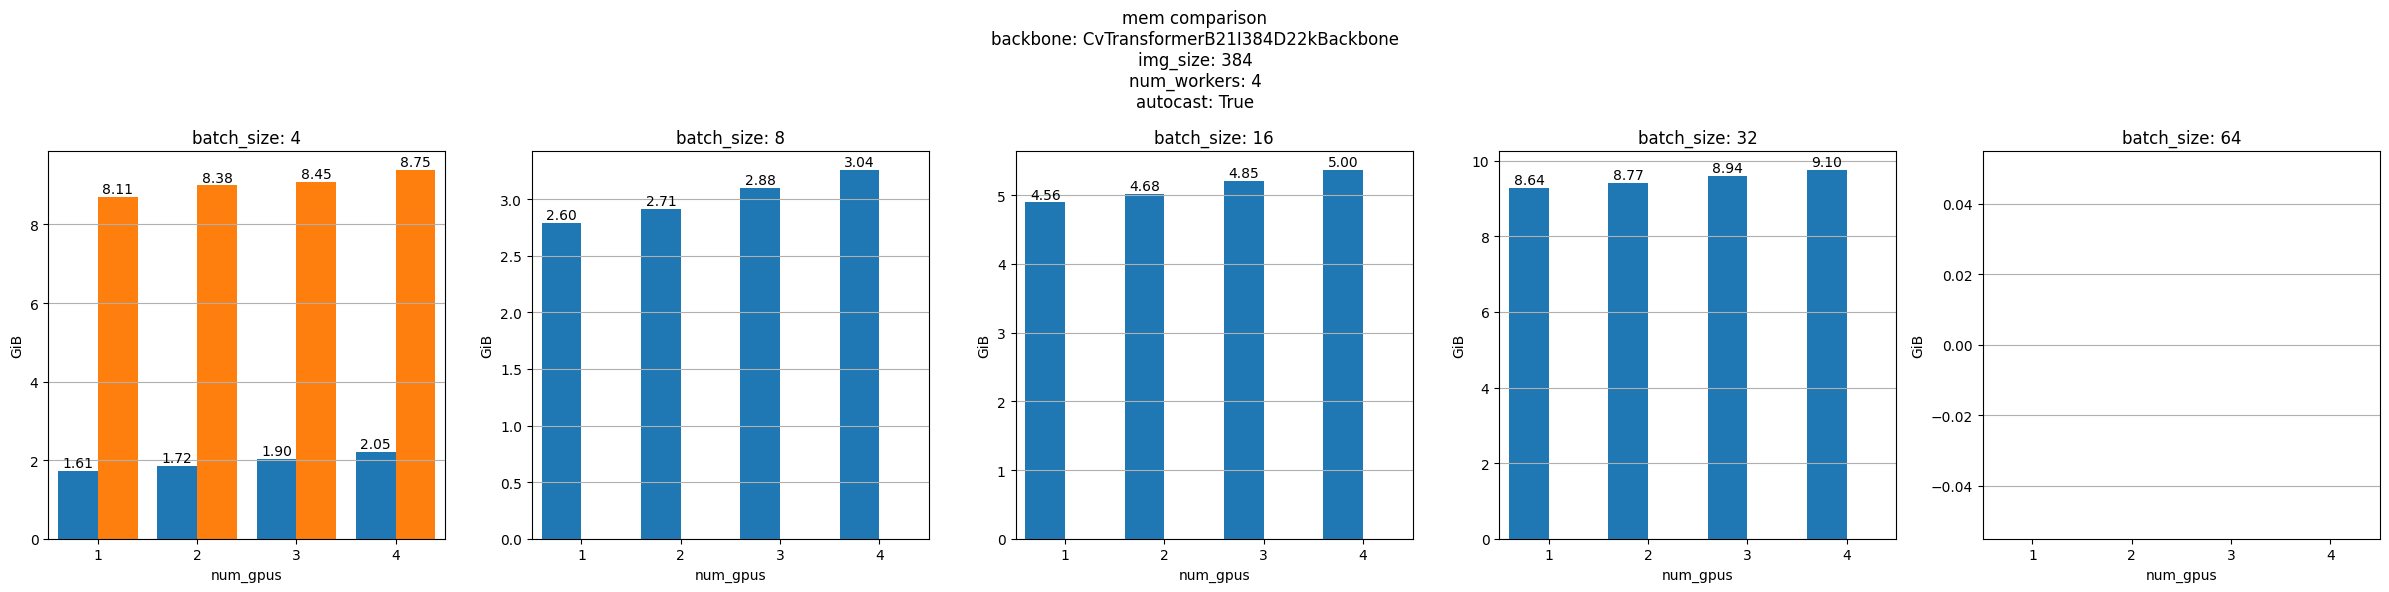

BACKBONE: EfficientNetV2SmallBackbone


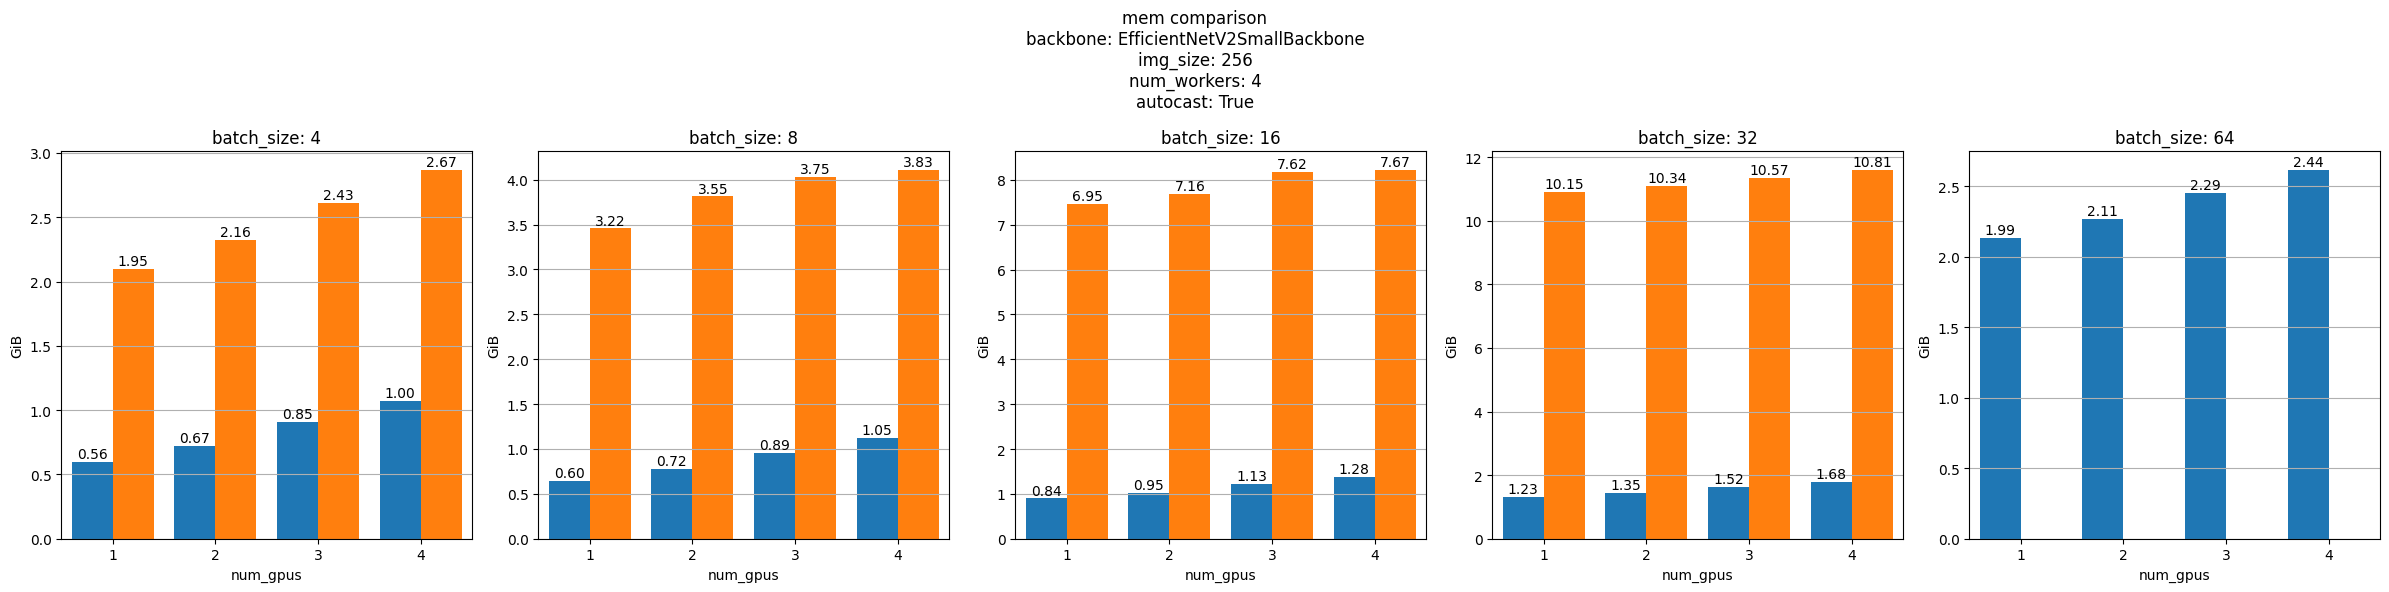

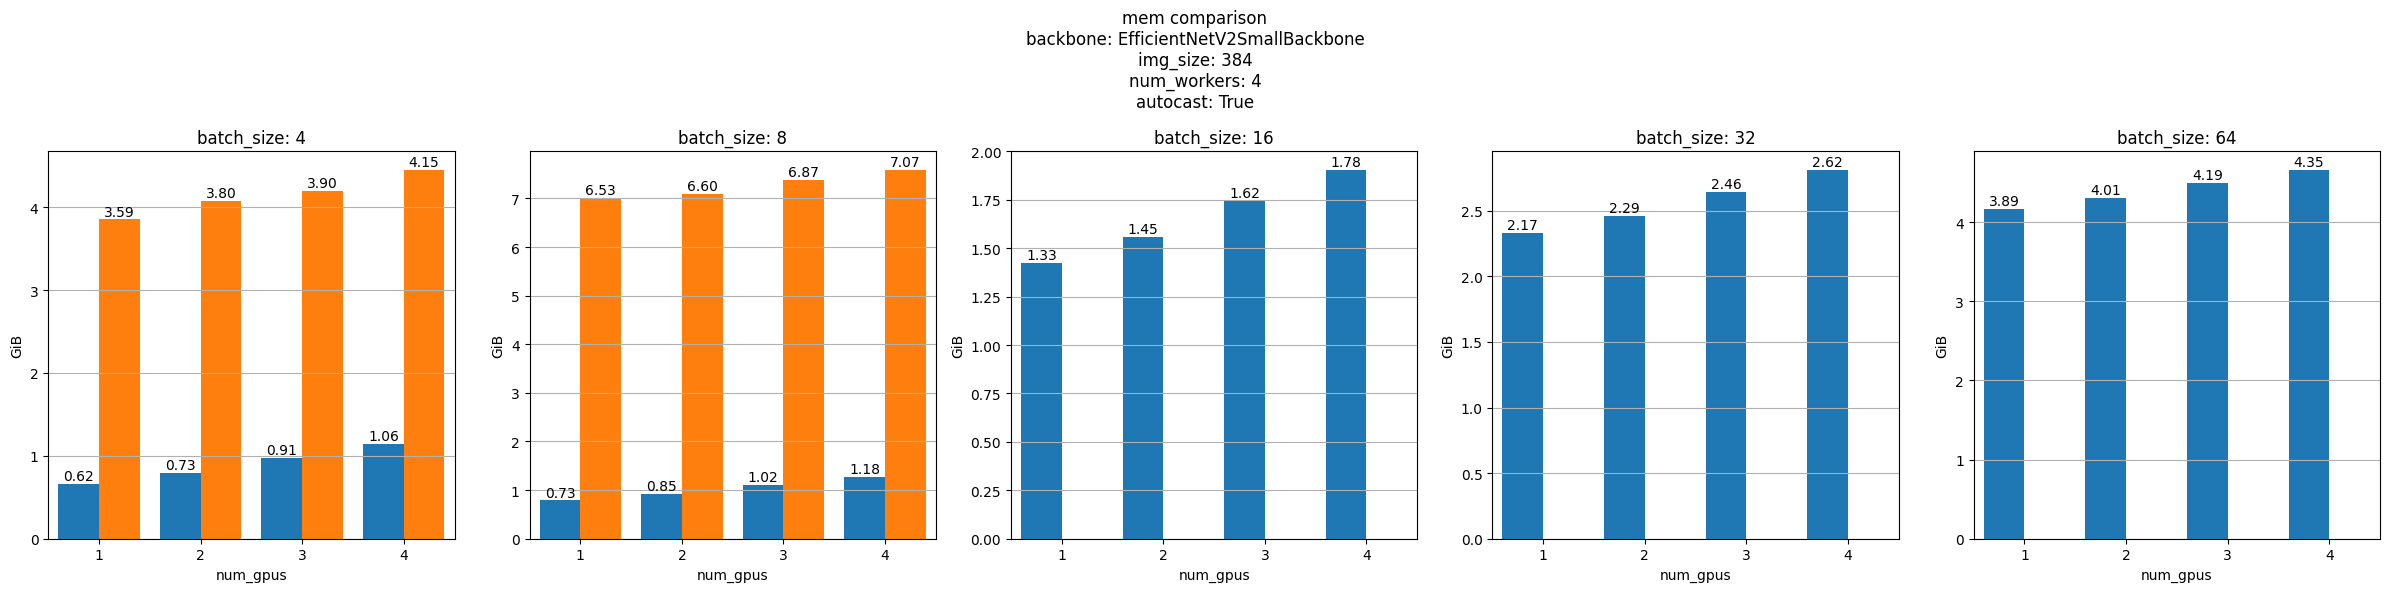

BACKBONE: SwinTransformerV2TinyBackbone


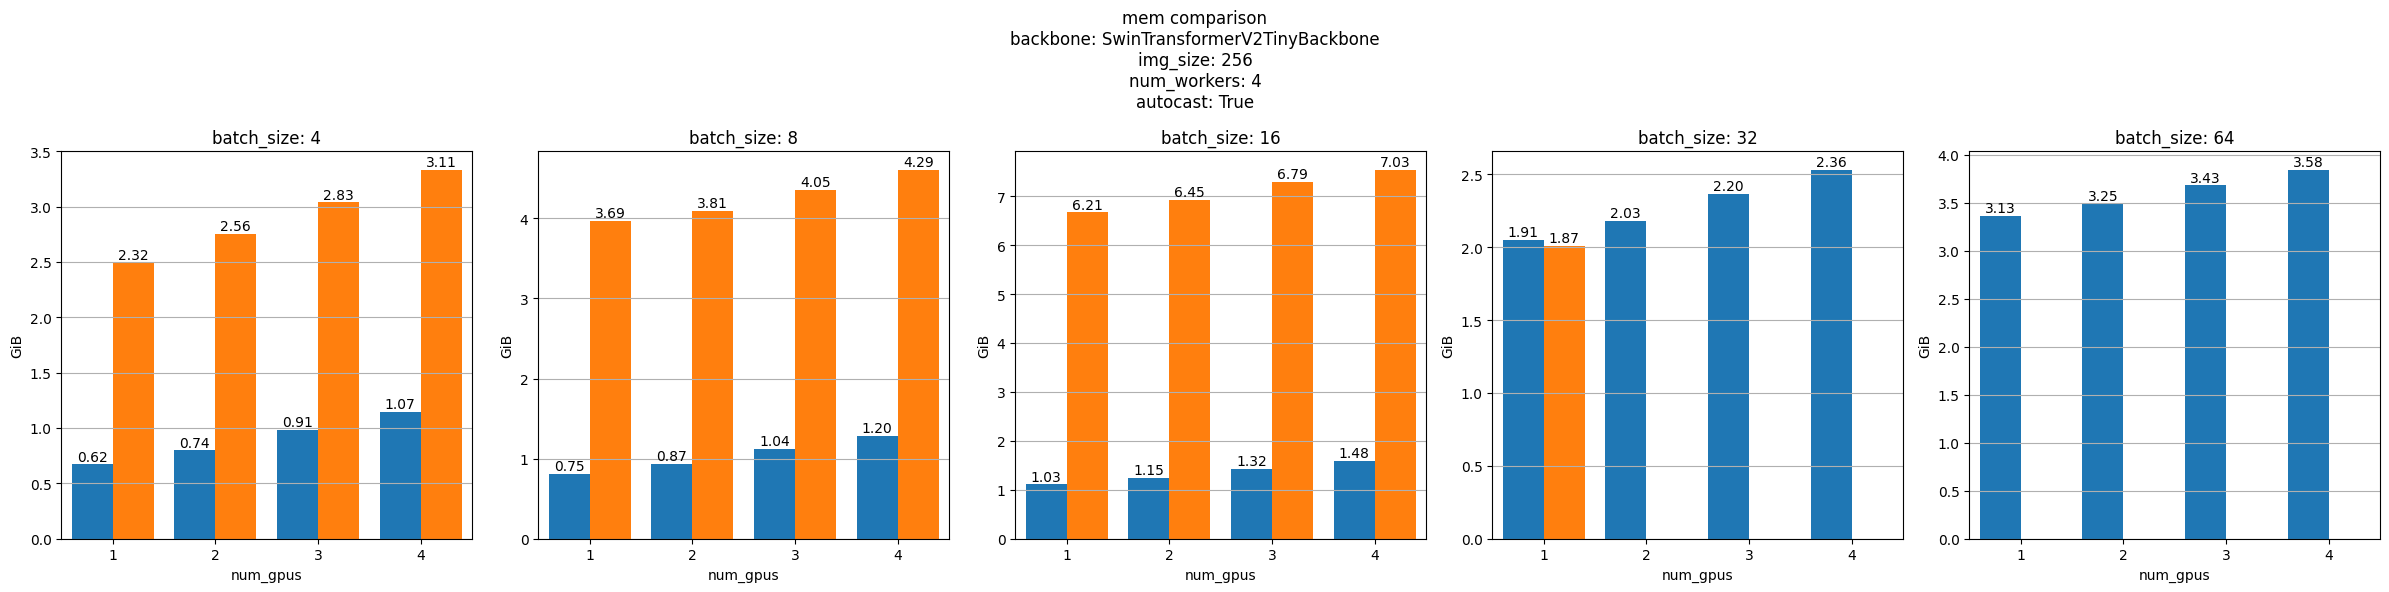

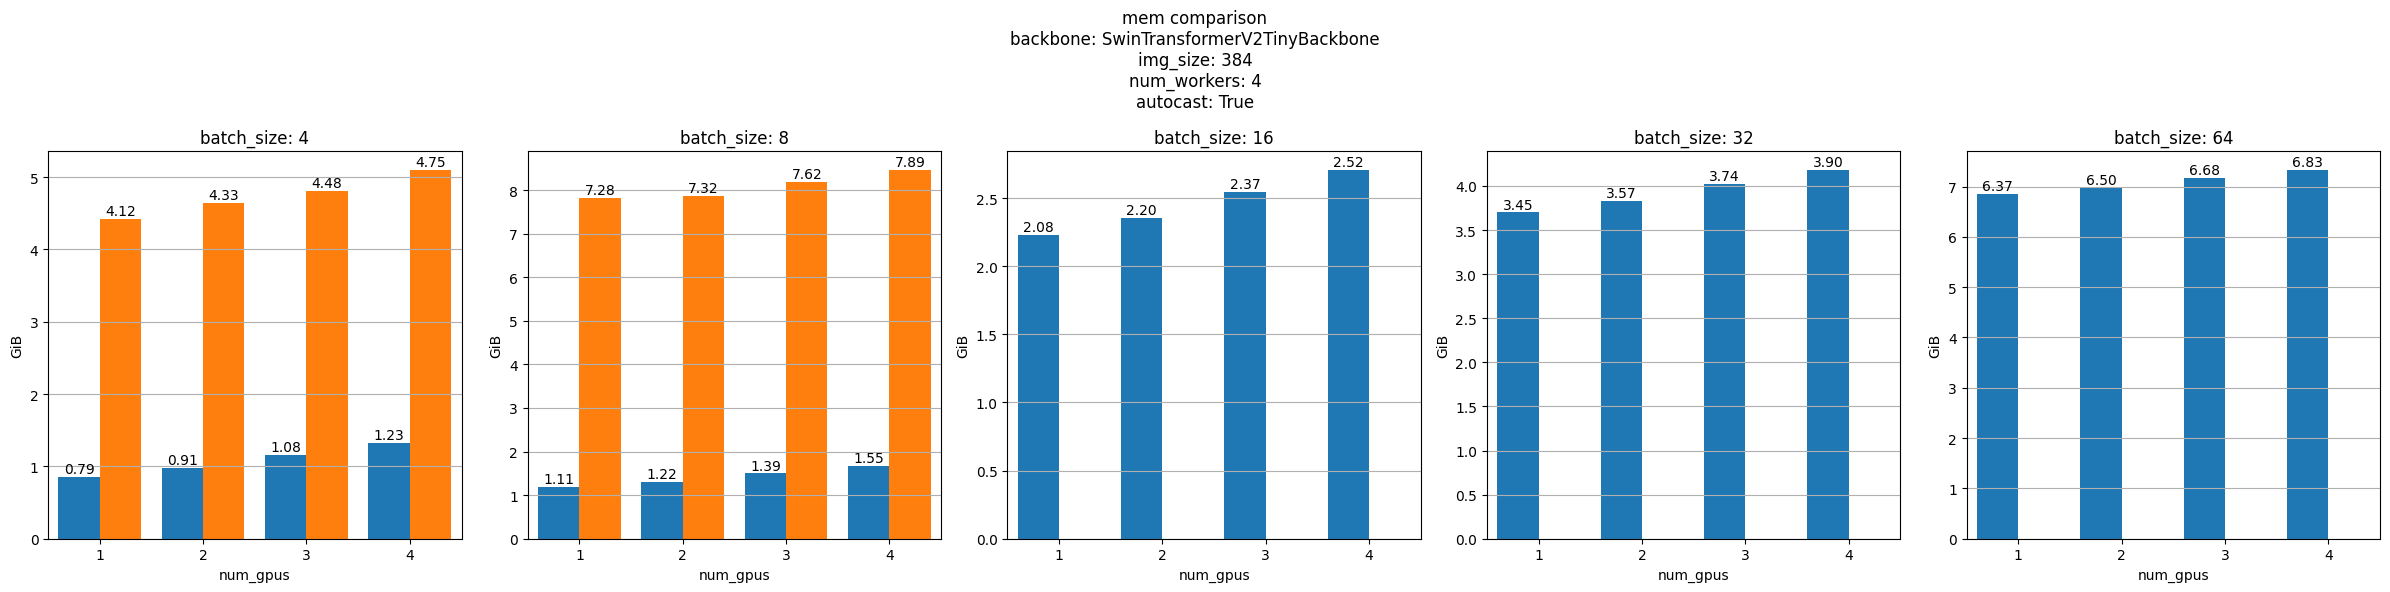

In [13]:
for backbone, in itertools.product(
    list(preview_data_df["backbone"].unique())
):

    print("BACKBONE:", backbone)

    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=256,
        num_workers=4,
        autocast=True,
        metric="mem"
    )
    
    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=384,
        num_workers=4,
        autocast=True,
        metric="mem"
    )

BACKBONE: CvTransformerB21I384D22kBackbone


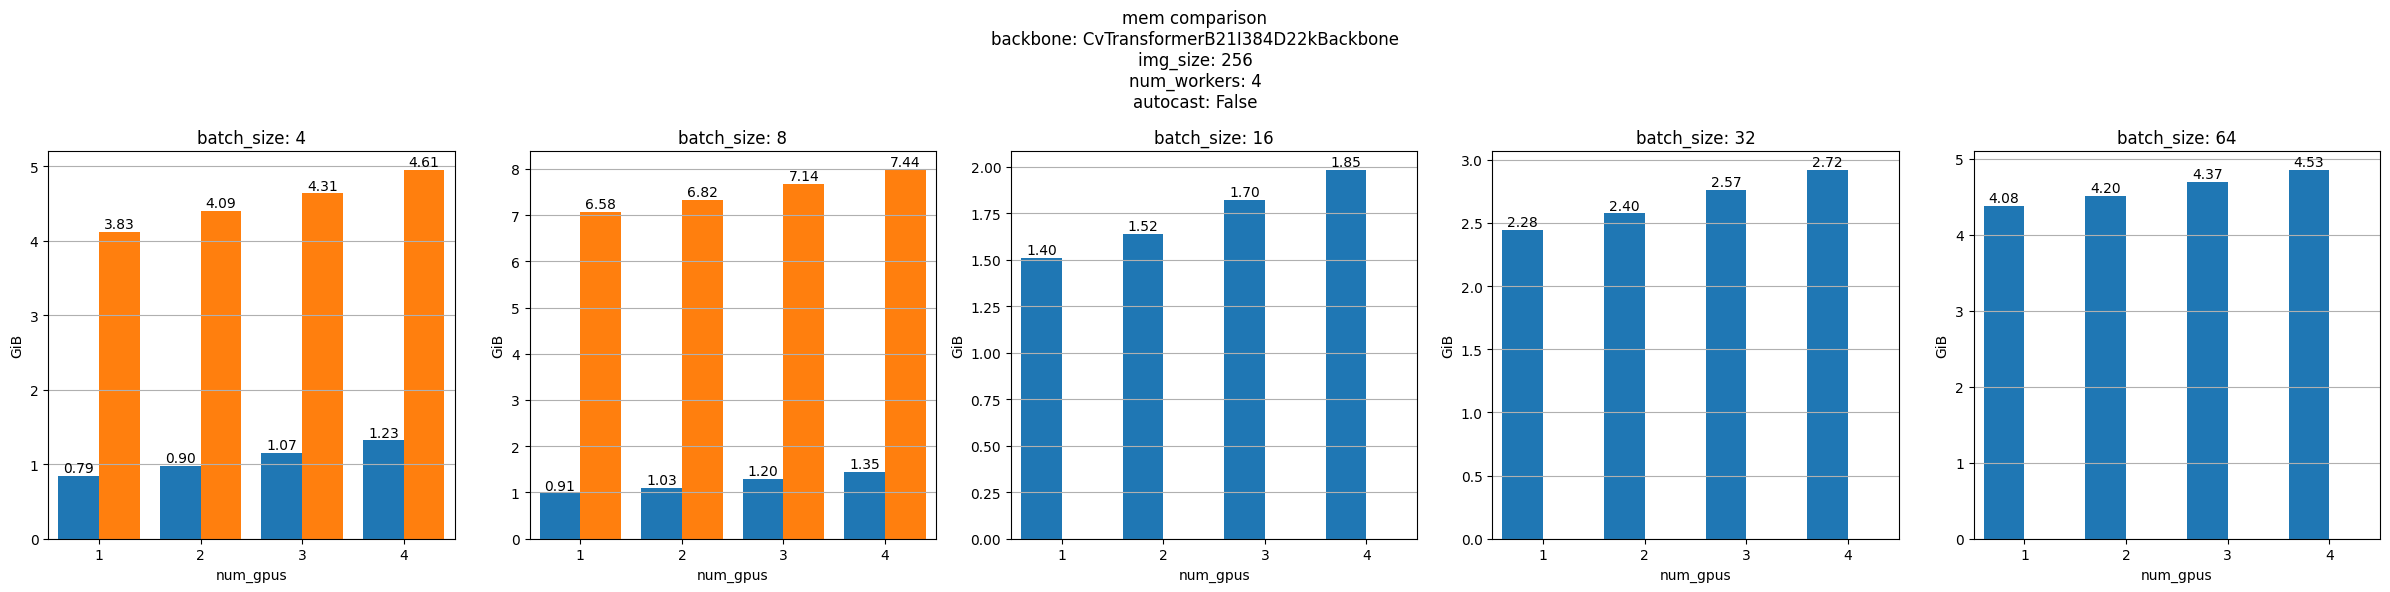

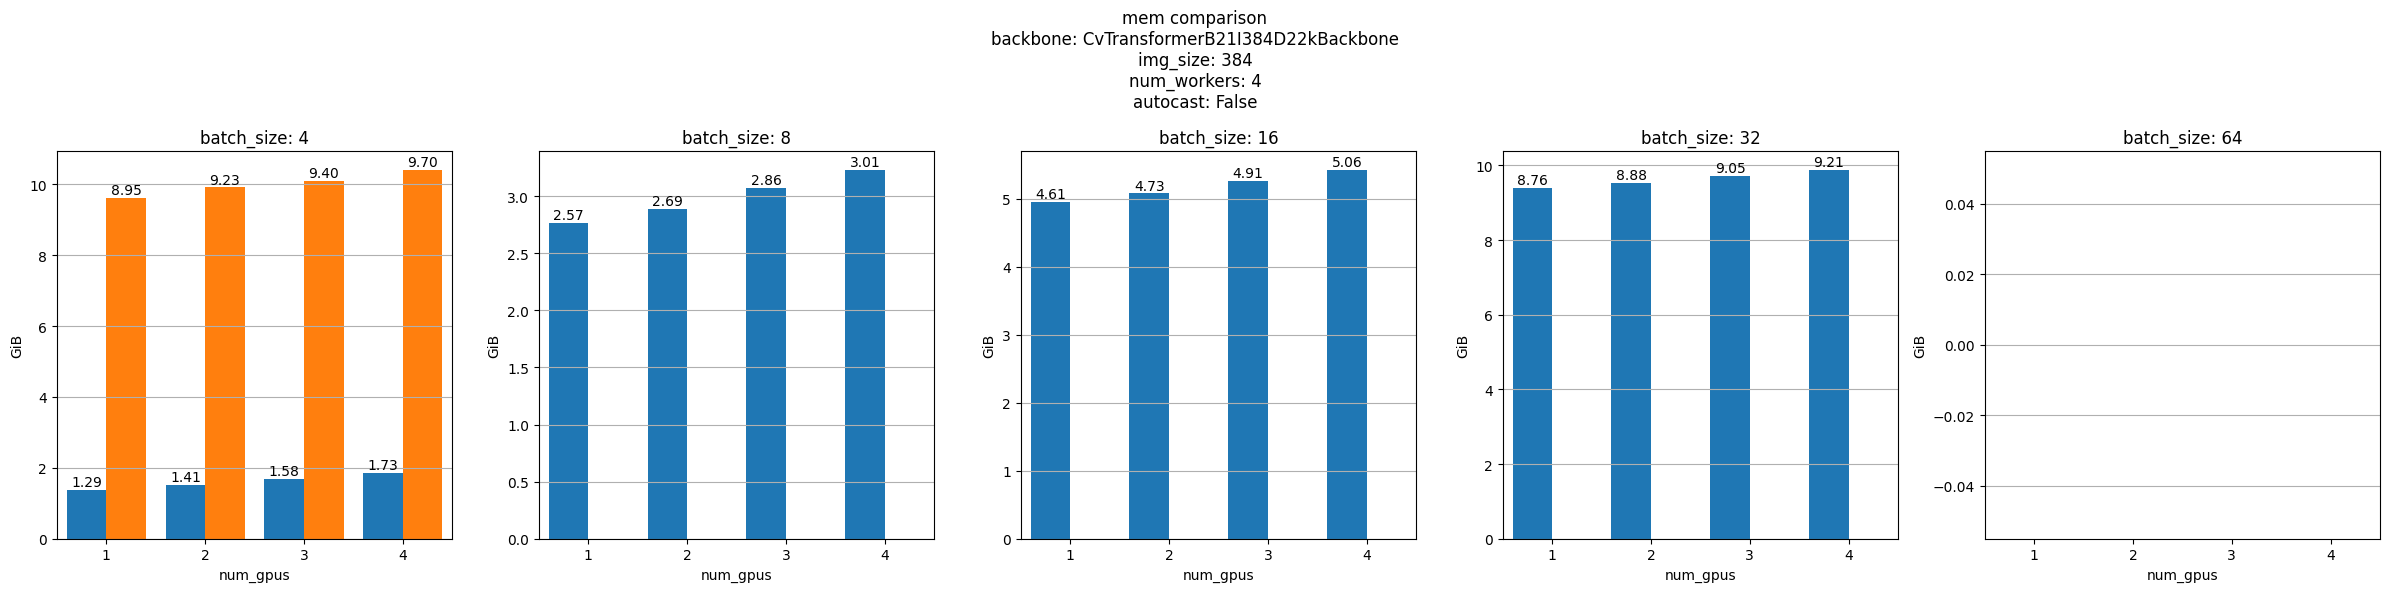

BACKBONE: EfficientNetV2SmallBackbone


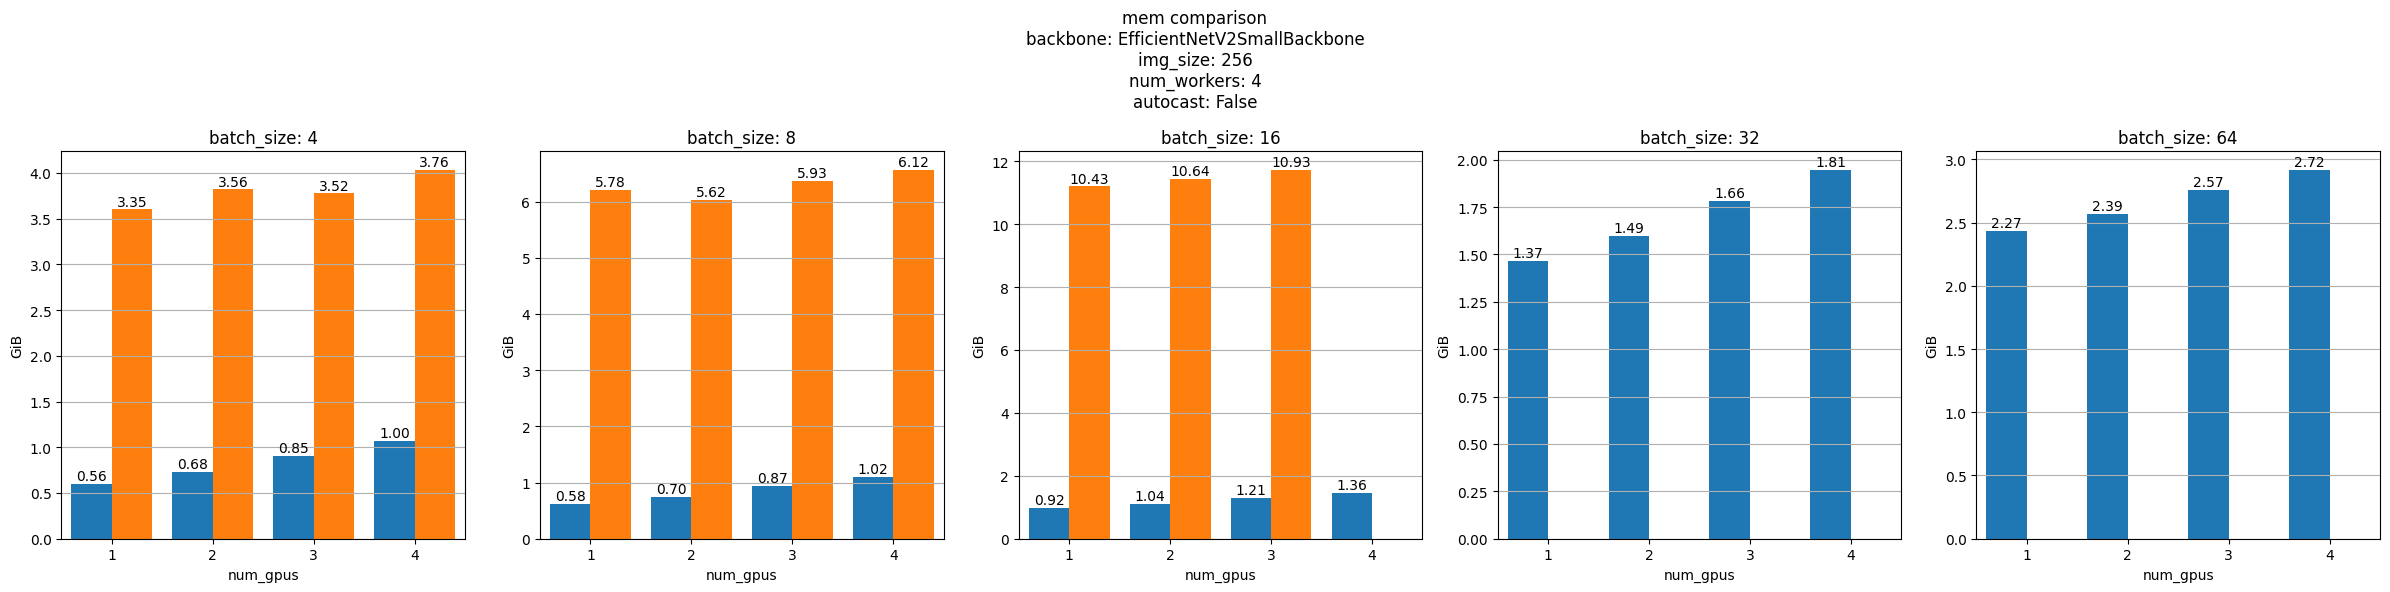

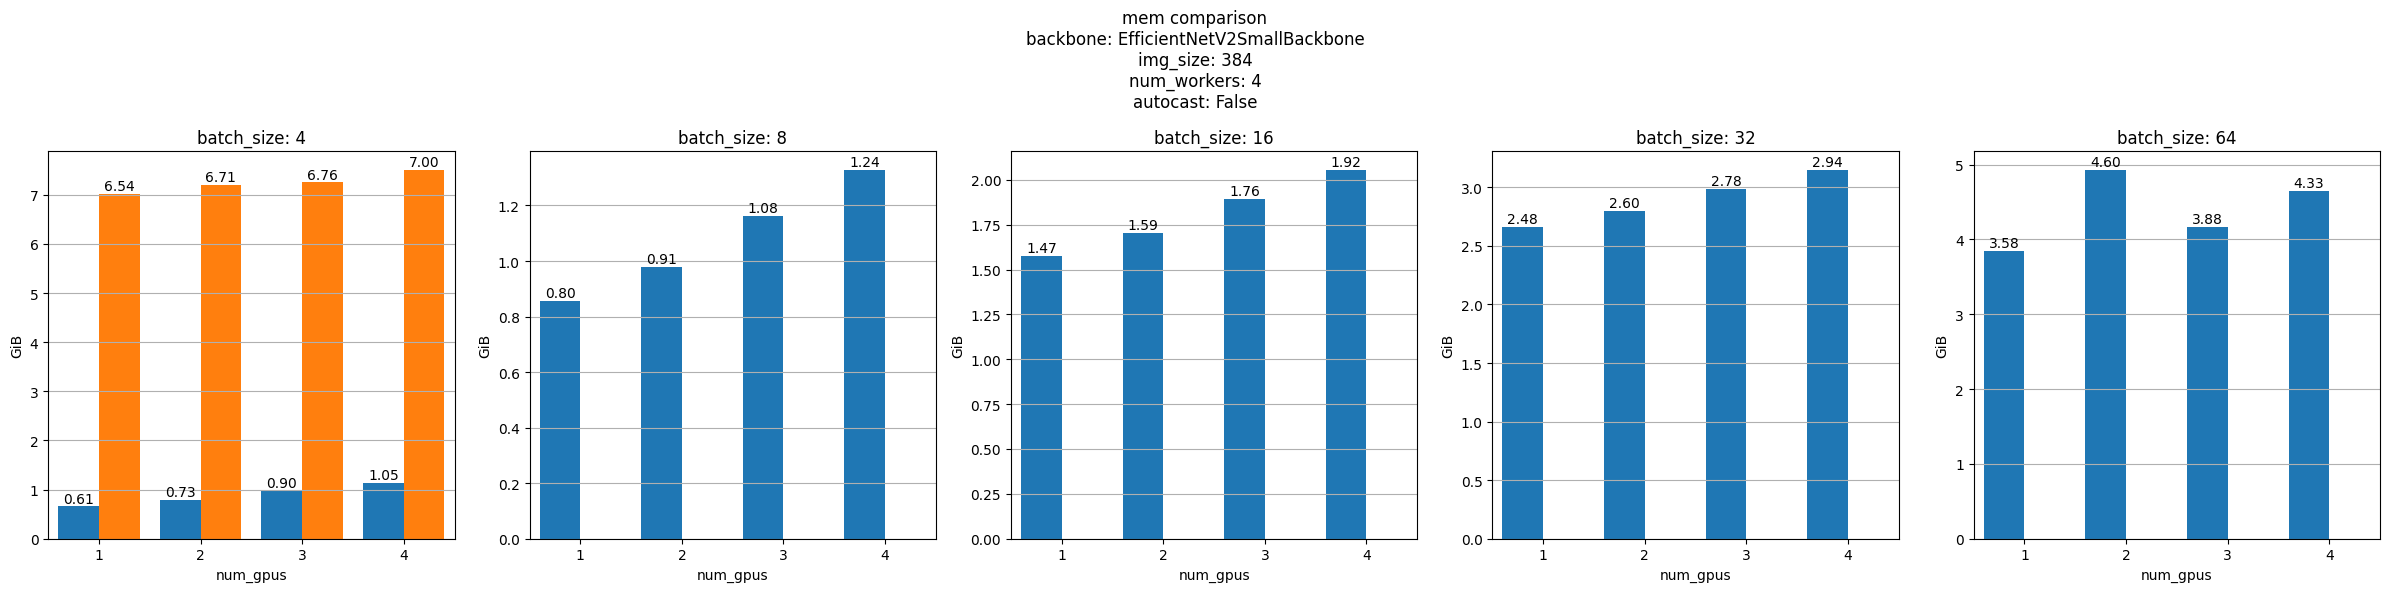

BACKBONE: SwinTransformerV2TinyBackbone


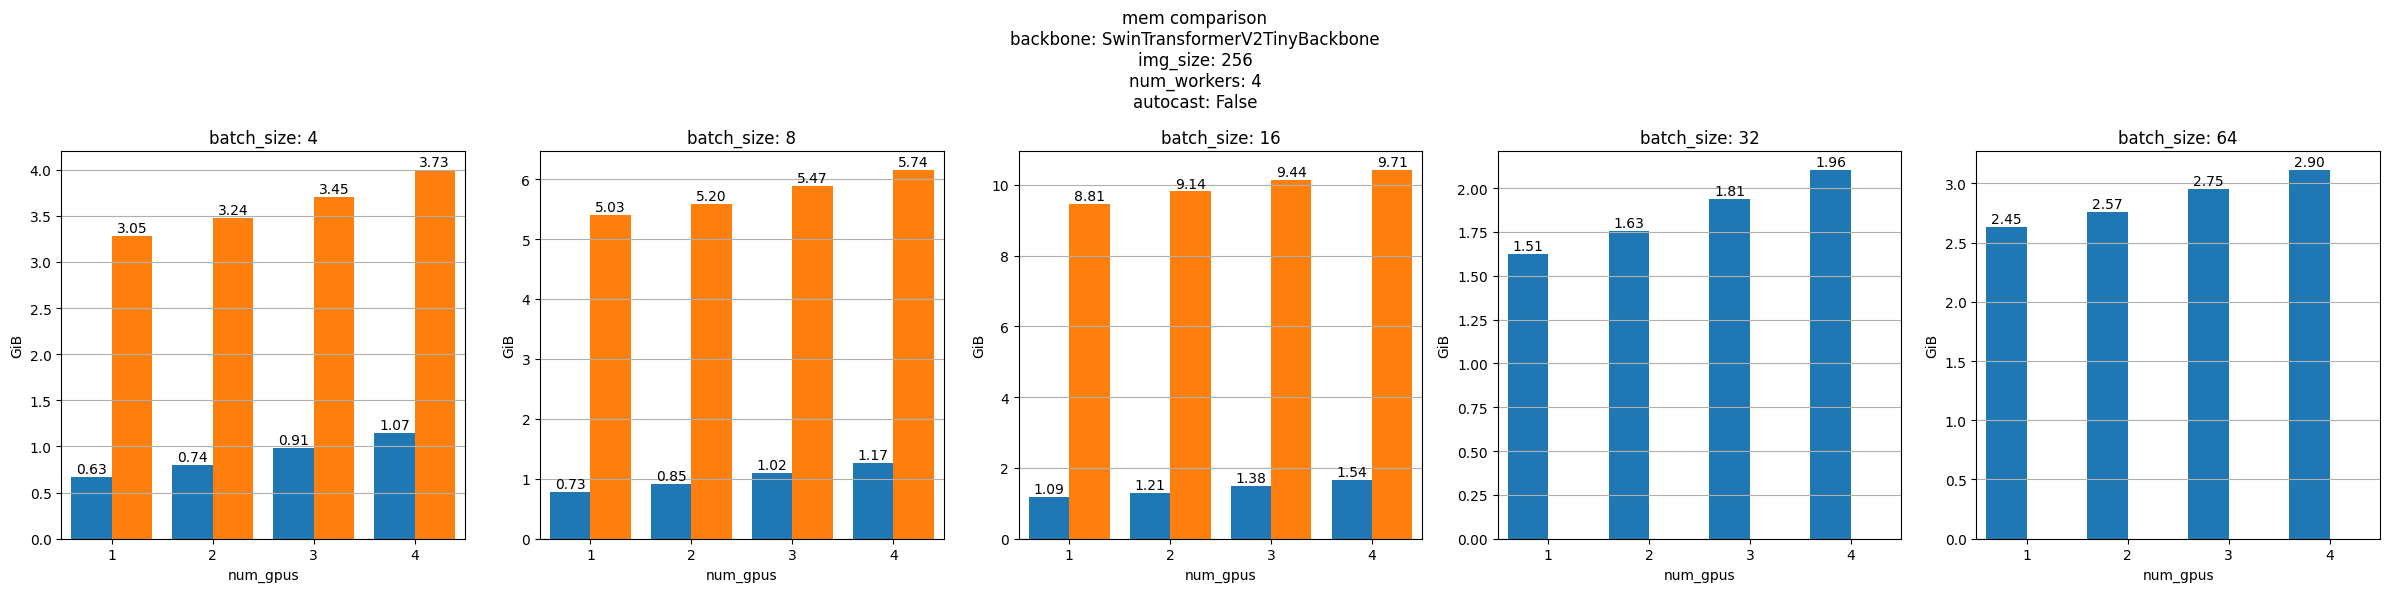

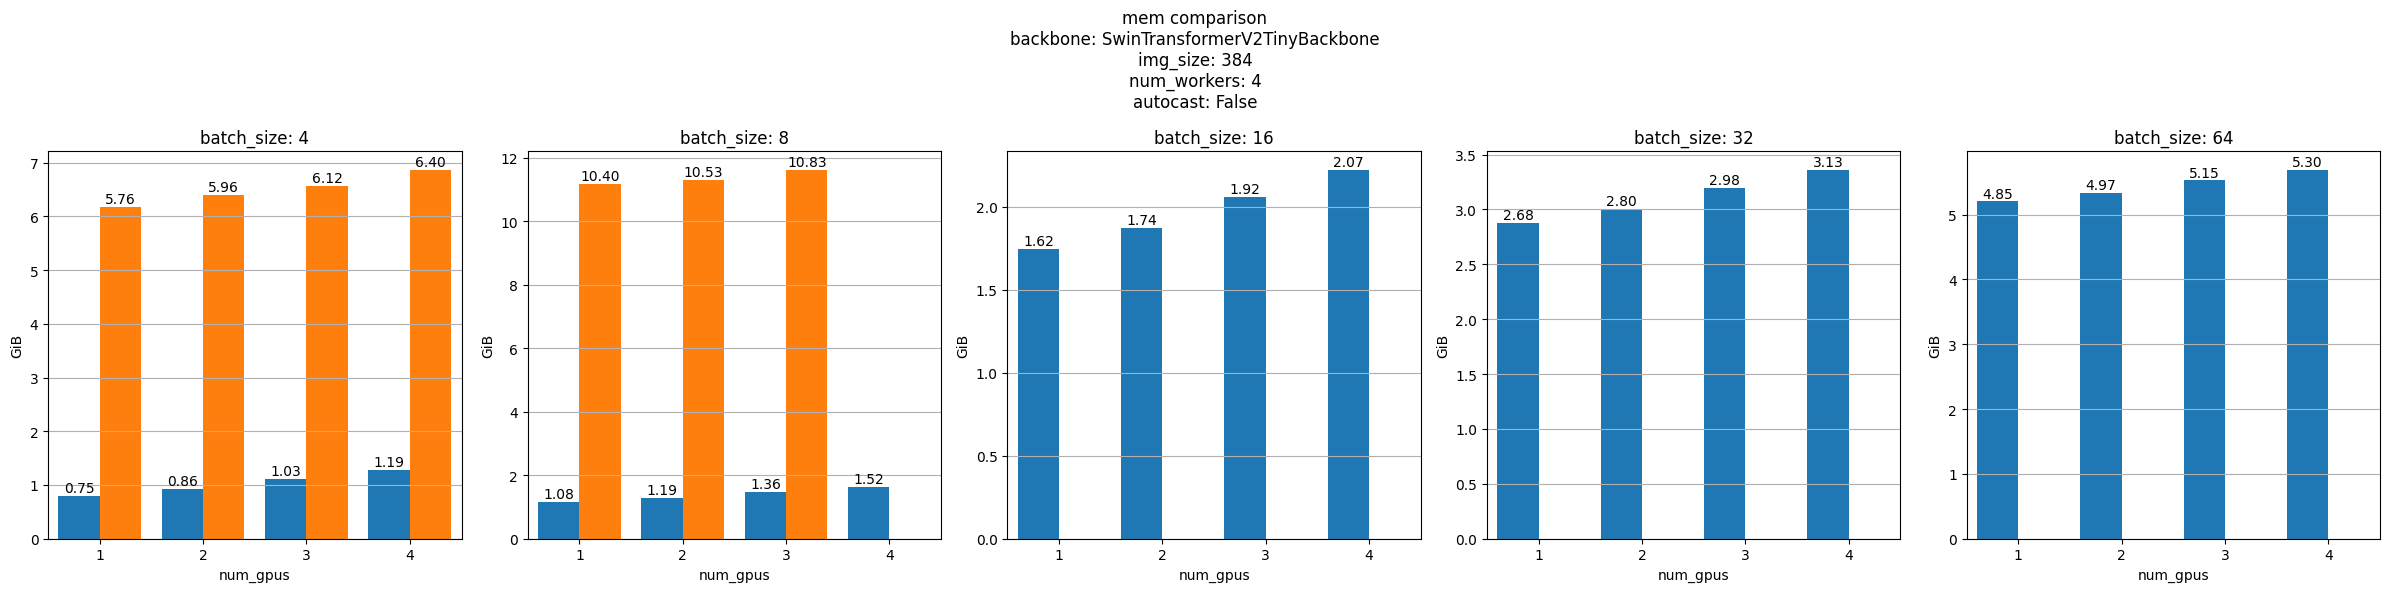

In [14]:
for backbone, in itertools.product(
    list(preview_data_df["backbone"].unique())
):

    print("BACKBONE:", backbone)

    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=256,
        num_workers=4,
        autocast=False,
        metric="mem"
    )
    
    plot_gpus_batch_size_comparison(
        backbone=backbone,
        img_size=384,
        num_workers=4,
        autocast=False,
        metric="mem"
    )